# **CUSTOMER CHURN PREDICTION**

**Importing necessary Libraries**

In [1]:
import os

#For numerical operations
import numpy as np
import pandas as pd

#For data visualizations
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


#For Data Preprocessing
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, cdist
from sklearn.metrics import silhouette_score

import yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer

#setting up the enivornment
pd.set_option('display.max_columns',None)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Model Building**


#### **The model can make wrong predictions as:**
When evaluating a customer churn prediction model, it is crucial to understand the types of errors the model can make and their implications. The model can make wrong predictions in two primary ways:

**1. False Positives (Type I Error):**
 - The model predicts that a customer will churn, but in reality, they do not.
 - Implication: The business may spend resources (e.g., discounts, offers) on retaining customers who were not going to leave, leading to unnecessary costs.

**2. False Negatives (Type II Error):**
- The model predicts that a customer will not churn, but in reality, they do.
- Implication: The business loses customers without attempting to retain them, resulting in lost revenue and potential damage to customer relationships.


#### **Which case is more important?**

**False Negatives are Often More Critical:** 

- Losing a customer (FN) is typically more costly than spending resources on retaining a customer who wasn't going to leave (FP).
- Retaining customers is usually cheaper than acquiring new ones, so missing a churning customer (FN) can have a higher long-term impact.

#### **Which metric to optimize?**.

Here are some widely used metrics for evaluating churn prediction models:

- **Accuracy:** Measures the proportion of correctly classified customers (both churners and non-churners). However, accuracy can be misleading in imbalanced datasets where the number of non-churners far exceeds churners.

- **Precision:** Measures the proportion of predicted churners who are actually churners. High precision means fewer false positives, which is important if retention efforts are expensive.

- **Recall (Sensitivity):** Measures the proportion of actual churners correctly identified by the model. High recall means fewer false negatives, which is critical if missing a churner is costly.

- **F1-Score:** The harmonic mean of precision and recall. It is a good metric when you want to balance both false positives and false negatives.

- **ROC-AUC:** Measures the model's ability to distinguish between churners and non-churners across different probability thresholds. A high AUC indicates a better-performing model.

Considering the Dataset:

  i. **Business Goal:** 
   Retain high-value customers who are likely to churn.

 ii. **Data Characteristics:** 
   Imbalanced dataset **(83.2% non-churners, 16.8% churners)**.

iii. **Metric Choice:** 
 Prioritize **Recall Score** to ensure that most high-value churners are identified, even if it means some false positives. 
 
 We will refine the model to improve precision by targeting retention efforts based on customer value.
 
 Optimize Recall when minimizing FNs is critical (e.g., when losing customers is more costly than retaining non-churning customers).
 
 We would want Recall-Score to be maximized, the greater the Recall-Score higher the chances of predicting FN classes correctly.

**Recall (Sensitivity):**

- **Formula:** Recall = TP / (TP + FN)
- **Implication:** Ensures that most churning customers are identified, even if it means some non-churning customers are flagged.

### **Data Preparation for Modelling**

#### **Importing necessary libraries**

In [2]:
import os

#For numerical operations
import numpy as np
import pandas as pd

import joblib

#setting up the enivornment
pd.set_option('display.max_columns',None)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.inspection import permutation_importance 


In [3]:
#1. Function to compute different metrics to check classification model performance
def model_performance_classification_sklearn(model, predictors, target):
    """
    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    pred = model.predict(predictors)
    acc = accuracy_score(target,pred)
    pre = precision_score(target,pred)
    rec = recall_score(target,pred)
    f1 = f1_score(target,pred)
    return pd.DataFrame({'Model':model.__class__.__name__,'Accuracy':acc,'Precision':pre,'Recall':rec,'F1-Score':f1}, index=[0])
     

#2. Function to plot the confusion_matrix with percentages

def confusion_matrix_sklearn(ax, model, predictors, target, title):
    """
    Plot confusion matrix with percentages.
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    
    labels = np.asarray(
        [["{0:0.0f}\n({1:.2%})".format(item, item / cm.sum())] 
         for item in cm.flatten()]
    ).reshape(cm.shape)
    
    sns.heatmap(cm, annot=labels, fmt="", cbar=False, ax=ax)
    ax.set_title(title, fontsize=10)
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    
#3.  defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_proba = model.predict(predictors)
    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    precision = precision_score(target, pred)  # to compute Precision
    recall = recall_score(target, pred)  # to compute Recall
    f1 = f1_score(target, pred)  # to compute F1-score
    roc_auc = roc_auc_score(target, pred_proba)

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {'Model':'LogisticRegression(statsmodel)',"Accuracy": acc, "Recall": recall, "Precision": precision, "F1-Score": f1,'ROC-AUC': roc_auc},
        index=[0],
    )
    return df_perf

#4. defining a function to plot the confusion_matrix of a classification model

def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show() 

In [4]:
# Reading the datasets
data_train_scaled = pd.read_csv('../data/processed/data_train_scaled.csv')
X_train_cleaned = data_train_scaled.drop(['Churn'],axis = 1)
y_train = data_train_scaled['Churn']

data_val = pd.read_csv('../data/processed/data_val.csv')
X_val = data_val.drop(['Churn'],axis = 1)
y_val = data_val['Churn']

data_test = pd.read_csv('../data/processed/data_test.csv')
X_test = data_test.drop(['Churn'],axis = 1)
y_test = data_test['Churn']

**Checking Class Distribution in y Dataset (post Train-Val-Test Split)**

In [5]:
# Check imbalance in y_train and y_test
print("\033[1mClass distribution in y_train:\033[0m\n")
print(y_train.value_counts(normalize=True))

print("\033[1m\nClass distribution in y_val:\033[0m\n")
print(y_val.value_counts(normalize=True))

print("\033[1m\nClass distribution in y_test:\033[0m\n")
print(y_test.value_counts(normalize=True))

Class distribution in y_train:

Churn
0    0.831529
1    0.168471
Name: proportion, dtype: float64

Class distribution in y_val:

Churn
0    0.831853
1    0.168147
Name: proportion, dtype: float64

Class distribution in y_test:

Churn
0    0.831705
1    0.168295
Name: proportion, dtype: float64


**Displaying First 5 rows of X_train Dataset:**

In [6]:
X_train_cleaned.head(5)

,City_Tier,CC_Contacted_LY,Service_Score,Account_user_count,account_segment,CC_Agent_Score,rev_per_month,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Loyalty_Score,Tenure_Group,Payment_COD,Payment_DC,Payment_UPI,Payment_Wallet,Gender_Male,Marital_Status_Married,Marital_Status_Single,Login_device_Mobile,Login_device_Others,Complain_ly_1.0
0,1.482521,-0.910111,1.520451,0.294278,-1.906083,0.688267,0.246171,-0.589003,0.220600,0.718960,0.447233,0.706488,-0.161299,-0.318323,-0.835420,-0.284904,2.880636,0.808635,-1.078872,-0.675970,0.680113,-0.224583,-0.607603
1,-0.707525,-0.443547,-1.246658,-0.708353,0.738359,-0.038528,-1.105636,-1.120304,0.220600,1.294895,-0.758599,-0.430170,-0.161299,-0.318323,1.197003,-0.284904,-0.347146,-1.236652,0.926894,-0.675970,-1.470345,-0.224583,-0.607603
2,-0.707525,-1.026752,-1.246658,1.296908,-0.143121,-0.038528,-0.091781,1.801852,-0.426649,-0.720878,-0.681827,-0.187724,1.291600,-0.318323,1.197003,-0.284904,-0.347146,0.808635,-1.078872,-0.675970,0.680113,-0.224583,-0.607603
3,-0.707525,1.422709,1.520451,0.294278,0.738359,-0.038528,-0.767684,-0.323353,0.220600,-0.432911,-0.286995,-1.104170,1.291600,-0.318323,1.197003,-0.284904,-0.347146,0.808635,-1.078872,1.479356,0.680113,-0.224583,-0.607603
4,1.482521,-0.210265,0.136896,0.294278,-1.906083,-1.492119,0.246171,-1.120304,2.162346,-0.144943,0.926016,1.584827,-0.161299,-0.318323,-0.835420,-0.284904,2.880636,0.808635,0.926894,-0.675970,0.680113,-0.224583,-0.607603


#### **Validation and Test data preparation for Modelling**

In [7]:
X_val_copy = X_val.copy()
X_test_copy = X_test.copy()


**Transforming X_val dataset:**

In [8]:

#Missing Value Treatments
columns_with_missing_values = joblib.load('../models/cols_for_imputation.pkl')
imputers = joblib.load('../models/col_imputers.pkl')

X_val[columns_with_missing_values['median']] = imputers['median'].transform(X_val[columns_with_missing_values['median']])
X_val[columns_with_missing_values['mode']] = imputers['mode'].transform(X_val[columns_with_missing_values['mode']])
X_val[columns_with_missing_values['mean']] = imputers['mean'].transform(X_val[columns_with_missing_values['mean']])
X_val['Account_user_count'] = X_val['Account_user_count'].astype(float)
print("Performed Missing-Value-Treatment")

#Outlier Treatment
outliers_cap_thresholds = joblib.load('../models/outliers_cap_thresholds.pkl')

# Define a function to cap outliers
def cap_outliers(df, thresholds):
    df_capped = df.copy()
    for col, threshold in thresholds.items():
        if col in df_capped.columns:
            df_capped[col] = df_capped[col].clip(upper=threshold)  # Cap values above threshold
    return df_capped

# Apply to validation/test sets
X_val = cap_outliers(X_val, outliers_cap_thresholds)

#Feature Engineering
X_val['Loyalty_Score'] = (X_val['Tenure']/X_val['Tenure'].max()) + (X_val['coupon_used_for_payment']/X_val['coupon_used_for_payment'].max()) + (X_val['rev_per_month']/X_val['rev_per_month'].max()) + (X_val['cashback']/X_val['cashback'].max()) - (X_val['CC_Contacted_LY']/X_val['CC_Contacted_LY'].max())
bins = [0, 4, 7, 13, 25, 100]
labels = ['New','Early','Growing', 'Established','Loyal']
X_val['Tenure_Group'] = pd.cut(X_val['Tenure'], bins=bins, labels=labels, right=False)
X_val.drop(['Tenure'],axis=1,inplace=True)
print("Performed Feature Engineering")

#Feature Encoding
ordinal_cols = joblib.load( '../models/ordinal_cols.pkl')
oe = joblib.load( '../models/oe.pkl')
nominal_cols = joblib.load( '../models/nominal_cols.pkl')
OHE = joblib.load('../models/OHE.pkl')
X_val[ordinal_cols] = oe.transform(X_val[ordinal_cols])
encoded = OHE.transform(X_val[nominal_cols])

encoded_df = pd.DataFrame(encoded, columns = OHE.get_feature_names_out(nominal_cols))
X_val.drop(nominal_cols,axis = 1,inplace=True)
X_val_encoded = pd.concat([X_val.reset_index(drop=True),encoded_df], axis = 1 )  
print(f'Performed Feature Encoding')

# #Feature Scaling
scaler = joblib.load( '../models/scaler.pkl')
scaled = scaler.transform(X_val_encoded)
X_val = pd.DataFrame(scaled, columns = X_val_encoded.columns)
# scaled = scaler.transform(X_val_encoded[scale_col_list])
# X_val[scale_col_list] = pd.DataFrame(scaled, columns = scale_col_list)
print("Performed Feature Scaling")


Performed Missing-Value-Treatment
Performed Feature Engineering
Performed Feature Encoding
Performed Feature Scaling


**Displaying First 5 rows of X_val dataset:**

In [9]:
X_val_cleaned = X_val.copy()
X_val_cleaned.head()

,City_Tier,CC_Contacted_LY,Service_Score,Account_user_count,account_segment,CC_Agent_Score,rev_per_month,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Loyalty_Score,Tenure_Group,Payment_COD,Payment_DC,Payment_UPI,Payment_Wallet,Gender_Male,Marital_Status_Married,Marital_Status_Single,Login_device_Mobile,Login_device_Others,Complain_ly_1.0
0,-0.707525,-1.143393,-1.246658,-0.708353,0.738359,0.688267,-0.091781,-1.385955,1.515097,2.158798,-0.506944,1.054228,-0.161299,-0.318323,1.197003,-0.284904,-0.347146,-1.236652,-1.078872,1.479356,0.680113,-0.224583,-0.607603
1,1.482521,-0.910111,-1.246658,0.294278,-1.024602,0.688267,-0.767684,-0.589003,-0.426649,1.006928,2.160962,0.696771,-0.887748,-0.318323,-0.835420,-0.284904,2.880636,-1.236652,0.926894,-0.675970,0.680113,-0.224583,-0.607603
2,1.482521,1.189427,-1.246658,0.294278,1.619840,-0.038528,-0.091781,-0.854654,2.162346,-1.296813,1.892756,1.057574,-1.614198,-0.318323,1.197003,-0.284904,-0.347146,0.808635,-1.078872,1.479356,-1.470345,4.452706,-0.607603
3,-0.707525,1.539350,-1.246658,-0.708353,-1.024602,0.688267,-0.091781,1.536201,-1.073897,-1.296813,2.015791,-0.501172,-0.887748,-0.318323,-0.835420,-0.284904,-0.347146,-1.236652,-1.078872,1.479356,-1.470345,-0.224583,-0.607603
4,-0.707525,-1.260034,1.520451,0.294278,1.619840,-0.765324,1.935930,1.801852,-0.426649,-0.144943,2.382307,2.101628,-0.887748,-0.318323,-0.835420,-0.284904,-0.347146,0.808635,0.926894,-0.675970,0.680113,-0.224583,-0.607603


**Transforming X_test dataset:**

In [10]:

#Missing Value Treatments
X_test[columns_with_missing_values['median']] = imputers['median'].transform(X_test[columns_with_missing_values['median']])
X_test[columns_with_missing_values['mode']] = imputers['mode'].transform(X_test[columns_with_missing_values['mode']])
X_test[columns_with_missing_values['mean']] = imputers['mean'].transform(X_test[columns_with_missing_values['mean']])
X_test['Account_user_count'] = X_test['Account_user_count'].astype(float)
print("Performed Missing-Value-Treatment")

#Outlier Treatment
X_test = cap_outliers(X_test, outliers_cap_thresholds)
print("Performed Outlier-Treatment")

#Feature Engineering
X_test['Loyalty_Score'] = (X_test['Tenure']/X_test['Tenure'].max()) + (X_test['coupon_used_for_payment']/X_test['coupon_used_for_payment'].max()) + (X_test['rev_per_month']/X_test['rev_per_month'].max()) + (X_test['cashback']/X_test['cashback'].max()) - (X_test['CC_Contacted_LY']/X_test['CC_Contacted_LY'].max())
bins = [0, 4, 7, 13, 25, 100]
labels = ['New','Early','Growing', 'Established','Loyal']
X_test['Tenure_Group'] = pd.cut(X_test['Tenure'], bins=bins, labels=labels, right=False)
X_test.drop(['Tenure'],axis=1,inplace=True)
print("Performed Feature Engineering")

#Feature Encoding
X_test[ordinal_cols] = oe.transform(X_test[ordinal_cols])
encoded = OHE.transform(X_test[nominal_cols])
encoded_df = pd.DataFrame(encoded, columns = OHE.get_feature_names_out(nominal_cols))
X_test.drop(nominal_cols,axis = 1,inplace=True)
X_test_encoded = pd.concat([X_test.reset_index(drop=True),encoded_df], axis = 1 )  
print(f'Performed Feature Encoding')

# #Feature Scaling
scaled = scaler.transform(X_test_encoded)
X_test = pd.DataFrame(scaled, columns = X_test_encoded.columns)
# scaled = scaler.transform(X_test_encoded[scale_col_list])
# X_test[scale_col_list] = pd.DataFrame(scaled, columns = scale_col_list)
print("Performed Feature Scaling")

Performed Missing-Value-Treatment
Performed Outlier-Treatment
Performed Feature Engineering
Performed Feature Encoding
Performed Feature Scaling


**Displaying First 5 rows of X_test dataset:**

In [11]:
X_test_cleaned = X_test.copy()
X_test_cleaned.head()

,City_Tier,CC_Contacted_LY,Service_Score,Account_user_count,account_segment,CC_Agent_Score,rev_per_month,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Loyalty_Score,Tenure_Group,Payment_COD,Payment_DC,Payment_UPI,Payment_Wallet,Gender_Male,Marital_Status_Married,Marital_Status_Single,Login_device_Mobile,Login_device_Others,Complain_ly_1.0
0,-0.707525,-0.443547,0.136896,1.296908,-0.143121,-0.038528,0.584123,-0.057702,0.220600,-0.432911,-0.271640,0.724246,-0.887748,-0.318323,-0.835420,-0.284904,-0.347146,0.808635,0.926894,-0.675970,0.680113,-0.224583,-0.607603
1,1.482521,-0.326906,1.520451,0.294278,0.738359,-1.492119,-0.767684,-0.323353,0.220600,0.143025,0.130171,-0.091689,-0.161299,-0.318323,-0.835420,-0.284904,-0.347146,0.808635,0.926894,-0.675970,0.680113,-0.224583,-0.607603
2,1.482521,-0.210265,1.520451,0.294278,0.738359,-0.038528,-0.091781,1.270551,-0.426649,-0.144943,0.052202,-0.213609,-0.161299,-0.318323,1.197003,-0.284904,-0.347146,-1.236652,0.926894,-0.675970,-1.470345,4.452706,-0.607603
3,1.482521,-0.443547,1.520451,2.299539,1.619840,0.688267,0.246171,-0.854654,2.809595,1.006928,2.416805,2.689606,-0.887748,3.141461,-0.835420,-0.284904,-0.347146,-1.236652,0.926894,-0.675970,0.680113,-0.224583,1.645812
4,-0.707525,-1.143393,0.136896,0.294278,-0.143121,-0.038528,-1.105636,-0.589003,-0.426649,-1.296813,-1.132294,-0.374467,-0.887748,-0.318323,1.197003,-0.284904,-0.347146,-1.236652,-1.078872,1.479356,0.680113,-0.224583,-0.607603


### **Initial Model Building (Build Various Models)**

#### **Logistic Regression (statsmodel)**

In [12]:
X_train_with_intercept = X_train_cleaned.copy()

X_train_with_intercept = sm.add_constant(X_train_with_intercept)


**Displaying First 5 rows of X_train dataset after adding constant**

In [13]:
X_train_with_intercept.head()

,const,City_Tier,CC_Contacted_LY,Service_Score,Account_user_count,account_segment,CC_Agent_Score,rev_per_month,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Loyalty_Score,Tenure_Group,Payment_COD,Payment_DC,Payment_UPI,Payment_Wallet,Gender_Male,Marital_Status_Married,Marital_Status_Single,Login_device_Mobile,Login_device_Others,Complain_ly_1.0
0,1.0,1.482521,-0.910111,1.520451,0.294278,-1.906083,0.688267,0.246171,-0.589003,0.220600,0.718960,0.447233,0.706488,-0.161299,-0.318323,-0.835420,-0.284904,2.880636,0.808635,-1.078872,-0.675970,0.680113,-0.224583,-0.607603
1,1.0,-0.707525,-0.443547,-1.246658,-0.708353,0.738359,-0.038528,-1.105636,-1.120304,0.220600,1.294895,-0.758599,-0.430170,-0.161299,-0.318323,1.197003,-0.284904,-0.347146,-1.236652,0.926894,-0.675970,-1.470345,-0.224583,-0.607603
2,1.0,-0.707525,-1.026752,-1.246658,1.296908,-0.143121,-0.038528,-0.091781,1.801852,-0.426649,-0.720878,-0.681827,-0.187724,1.291600,-0.318323,1.197003,-0.284904,-0.347146,0.808635,-1.078872,-0.675970,0.680113,-0.224583,-0.607603
3,1.0,-0.707525,1.422709,1.520451,0.294278,0.738359,-0.038528,-0.767684,-0.323353,0.220600,-0.432911,-0.286995,-1.104170,1.291600,-0.318323,1.197003,-0.284904,-0.347146,0.808635,-1.078872,1.479356,0.680113,-0.224583,-0.607603
4,1.0,1.482521,-0.210265,0.136896,0.294278,-1.906083,-1.492119,0.246171,-1.120304,2.162346,-0.144943,0.926016,1.584827,-0.161299,-0.318323,-0.835420,-0.284904,2.880636,0.808635,0.926894,-0.675970,0.680113,-0.224583,-0.607603


In [14]:
# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_with_intercept).fit()

# Print summary
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.299562
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7206
Model:                          Logit   Df Residuals:                     7182
Method:                           MLE   Df Model:                           23
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.3394
Time:                        19:51:58   Log-Likelihood:                -2158.6
converged:                       True   LL-Null:                       -3267.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.5404      0.058    -43.507      0.000      -2.655   

**Observations**

- **Pseudo R-squared:** 0.3394 (pseudo R-squared value indicates the goodness of fit (closer to 1 is better)).

- **LLR p-value:** 0.000 The p-value of the Likelihood Ratio Test. The model is significantly better than the null model (p-value < 0.05).


- **City_Tier, Account_user_count, CC_Agent_Score, rev_per_month, coupon_used_for_payment, cashback, Tenure_Group, Payment_COD, Payment_Wallet, Gender_Male, Marital_Status_Single, Complain_ly_1.0:** Positive coefficients increase the likelihood of the target being 1 (e.g., churn).


- **CC_Contacted_LY, account_segment, rev_growth_yoy, Day_Since_CC_connect, Loyalty_Score, Login_device_Mobile, Login_device_Others :** These are having Negative coefficients decrease the likelihood.
  
- Negative values of the coefficient shows that probability of customer being a defaulter decreases with the increase of corresponding attribute value.

- Positive values of the coefficient show that that probability of customer being a defaulter increases with the increase of corresponding attribute value.

- p-value of a variable indicates if the variable is significant or not. If we consider the significance level to be 0.05 (5%), then any variable with a p-value less than 0.05 would be considered significant.

- But these variables might contain multicollinearity, which will affect the p-values.

* We will have to remove multicollinearity from the data to get reliable coefficients and p-values.

* There are different ways of detecting (or testing) multi-collinearity, one such way is the Variation Inflation Factor.

* **Variance  Inflation  factor**:  Variance  inflation  factors  measure  the  inflation  in  the variances of the regression coefficients estimates due to collinearity that exist among the  predictors.  It  is  a  measure  of  how  much  the  variance  of  the  estimated  regression coefficient βk is "inflated" by  the  existence  of  correlation  among  the  predictor variables in the model.

* General Rule of thumb: If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and  hence  the variance of β̂k is not inflated at all. Whereas if VIF exceeds 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity. But the purpose of the analysis should dictate which threshold to use.

##### **Multi Collinearity Check for Each features**

In [15]:

print(f'\033[1mNo. of Features in X_train: {len(X_train_with_intercept.columns)}\033[0m\n')

print(X_train_with_intercept.columns)

No. of Features in X_train: 24

Index(['const', 'City_Tier', 'CC_Contacted_LY', 'Service_Score',
       'Account_user_count', 'account_segment', 'CC_Agent_Score',
       'rev_per_month', 'rev_growth_yoy', 'coupon_used_for_payment',
       'Day_Since_CC_connect', 'cashback', 'Loyalty_Score', 'Tenure_Group',
       'Payment_COD', 'Payment_DC', 'Payment_UPI', 'Payment_Wallet',
       'Gender_Male', 'Marital_Status_Married', 'Marital_Status_Single',
       'Login_device_Mobile', 'Login_device_Others', 'Complain_ly_1.0'],
      dtype='object')


In [16]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_with_intercept.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_with_intercept.values, i) for i in range(X_train_with_intercept.shape[1])]
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
12,Loyalty_Score,17.111444
9,coupon_used_for_payment,5.888786
2,CC_Contacted_LY,4.283434
7,rev_per_month,4.083590
11,cashback,3.609709
20,Marital_Status_Single,2.175280
19,Marital_Status_Married,2.151073
17,Payment_Wallet,1.599868
15,Payment_DC,1.373348
1,City_Tier,1.372658


**Removing features with High VIF values one at a time**

**1. Removing Loyalty_Score with VIF = 17.111444**

In [17]:
X_train1_with_intercept= X_train_with_intercept.drop(["Loyalty_Score"],axis=1)

**Re-fitting the model on the updated X_train**

In [18]:
logit_model2 = sm.Logit(y_train, X_train1_with_intercept).fit()

# Print summary
print(logit_model2.summary())

Optimization terminated successfully.
         Current function value: 0.305588
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7206
Model:                          Logit   Df Residuals:                     7183
Method:                           MLE   Df Model:                           22
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.3261
Time:                        19:51:58   Log-Likelihood:                -2202.1
converged:                       True   LL-Null:                       -3267.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.5196      0.058    -43.587      0.000      -2.633   

In [19]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train1_with_intercept.columns
vif_data["VIF"] = [variance_inflation_factor(X_train1_with_intercept.values, i) for i in range(X_train1_with_intercept.shape[1])]
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
19,Marital_Status_Single,2.174993
18,Marital_Status_Married,2.151058
16,Payment_Wallet,1.599867
14,Payment_DC,1.372853
1,City_Tier,1.371342
10,Day_Since_CC_connect,1.290158
9,coupon_used_for_payment,1.253505
11,cashback,1.247629
13,Payment_COD,1.186897
3,Service_Score,1.179781


##### **Removing features with p value >0.05 which are insignificant**

* Let's remove the insignificant features (p-value>0.05).
* **Service_Score, Payment_DC, Payment_UPI and Marital_Status_Married** have a high p-value. So, they are not significant and we'll drop them.



* But sometimes p-values change after dropping a variable. So, we'll not drop all variables at once.

* Instead, we will do the following repeatedly using a loop:
  - Build a model, check the p-values of the variables, and drop the column with the highest p-value.
  - Create a new model without the dropped feature, check the p-values of the variables, and drop the column with the highest p-value.
  - Repeat the above two steps till there are no columns with p-value > 0.05.

The above process can also be done manually by picking one variable at a time that has a high p-value, dropping it, and building a model again. But that might be a little tedious and using a loop will be more efficient.

In [20]:
# initial list of columns
cols = X_train1_with_intercept.columns.tolist()

# setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    # defining the train set
    X_train_aux = X_train1_with_intercept[cols]

    # fitting the model
    model = sm.Logit(y_train, X_train_aux).fit(disp=False)

    # getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)

    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(f'\033[1mNo. of Significant Features: {len(selected_features)}\033[0m\n')

print(selected_features)

No. of Significant Features: 19

['const', 'City_Tier', 'CC_Contacted_LY', 'Account_user_count', 'account_segment', 'CC_Agent_Score', 'rev_per_month', 'rev_growth_yoy', 'coupon_used_for_payment', 'Day_Since_CC_connect', 'cashback', 'Tenure_Group', 'Payment_COD', 'Payment_Wallet', 'Gender_Male', 'Marital_Status_Single', 'Login_device_Mobile', 'Login_device_Others', 'Complain_ly_1.0']


The above columns are the significant columns


In [21]:
# creating a new training set
X_train2_with_intercept = X_train1_with_intercept[selected_features]
print(f'\033[1mNo. of Features in updated Train dataset: {len(X_train2_with_intercept.columns)}\033[0m\n')

No. of Features in updated Train dataset: 19



**Re-fitting the model on the updated X_train**

In [22]:
logit_model3 = sm.Logit(y_train, X_train2_with_intercept).fit()
# Print summary
print(logit_model3.summary())

Optimization terminated successfully.
         Current function value: 0.306147
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7206
Model:                          Logit   Df Residuals:                     7187
Method:                           MLE   Df Model:                           18
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.3249
Time:                        19:51:59   Log-Likelihood:                -2206.1
converged:                       True   LL-Null:                       -3267.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.5169      0.058    -43.599      0.000      -2.630   

**Converting coefficients to odds**
* The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients.
* Therefore, **odds =  exp(b)**
* The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

In [23]:
# converting coefficients to odds
odds = np.exp(logit_model3.params)

# finding the percentage change
perc_change_odds = (np.exp(logit_model3.params) - 1) * 100

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train2_with_intercept.columns)

,Odds,Change_odd%
const,0.080713,-91.928698
City_Tier,1.317361,31.736133
CC_Contacted_LY,1.296239,29.623933
Account_user_count,1.366571,36.657063
account_segment,0.640596,-35.940398
CC_Agent_Score,1.462075,46.207548
rev_per_month,1.366669,36.666896
rev_growth_yoy,0.887871,-11.212908
coupon_used_for_payment,1.355570,35.556997
Day_Since_CC_connect,0.671923,-32.807710


##### **Coefficient interpretations**

* **City_Tier**: Holding all other features constant a unit change in City_Tier will increase the odds of a customer being churned by 1.31 times or a 31.73% increase in odds.
* **CC_Contacted_LY**: Holding all other features constant a unit change in CC_Contacted_LY will increase the odds of a customer being churned by 1.29 times or a 29.62% increase in the odds.
* **Account_user_count**: Holding all other features constant a unit change in no. of users in an account will increase the odds of a customer being churned by 1.37 times or a 36.66% increase in the odds.
* **account_segment**: Holding all other features constant a unit change in account_segment will decrease the odds of a customer being churned by 0.64 times or a 35.94% decrease in the odds.

Interpretation for other attributes can be done similarly.

##### **Checking Logistic Regression model performance on the training set**

**Logistic Regression - Performance Metrics**

In [24]:
model_performance_classification_statsmodels(logit_model3, X_train2_with_intercept, y_train)

,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC
0,LogisticRegression(statsmodel),0.882182,0.456343,0.745626,0.566173,0.865096


**Logistic Regression - Confusion Matrix**

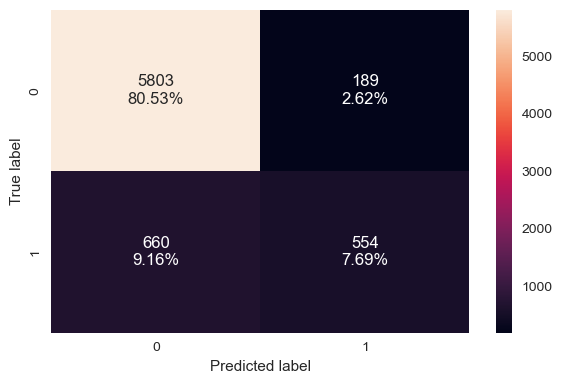

In [25]:
confusion_matrix_statsmodels(logit_model3, X_train2_with_intercept, y_train)

**Logistic Regression - ROC-AUC Curve**

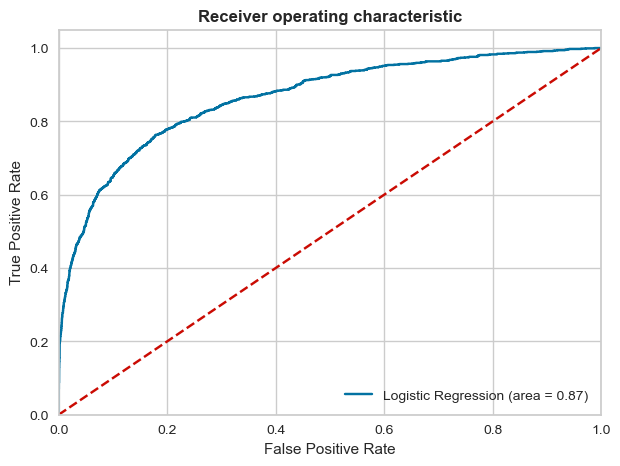

In [26]:
logit_roc_auc_train = roc_auc_score(y_train, logit_model3.predict(X_train2_with_intercept))
fpr, tpr, thresholds = roc_curve(y_train, logit_model3.predict(X_train2_with_intercept))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic",fontweight='bold')
plt.legend(loc="lower right")
plt.show()

Model has an AUC of 0.87, which is relatively good. This means, overall, the model is fairly good at ranking actual churners above non-churners.

**Finding Optimal threshold from ROC-AUC Curve**

In [27]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train, logit_model3.predict(X_train2_with_intercept))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.20572947518472878


**Logistic Regression - Performance Metrics with Optimal Threshold**

In [28]:
model_performance_classification_statsmodels(logit_model3, X_train2_with_intercept, y_train, threshold=optimal_threshold_auc_roc)


,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC
0,LogisticRegression(statsmodel),0.81113,0.762768,0.463232,0.576408,0.865096


**Logistic Regression - Confusion Matrix with Optimal Threshold**

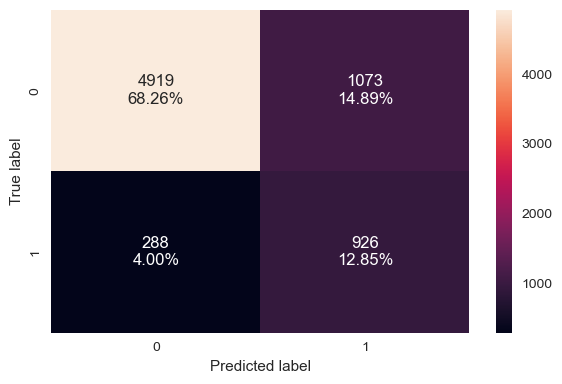

In [29]:
confusion_matrix_statsmodels(logit_model3, X_train2_with_intercept, y_train,threshold = optimal_threshold_auc_roc)

- Model performance has improved significantly.
- Model is giving a recall of 0.76 as compared to initial model which was giving a recall of 0.46.
- Precision has decreased from 0.75 to 0.46.

**Logistic Regression - ROC-AUC Curve with Optimal Threshold**

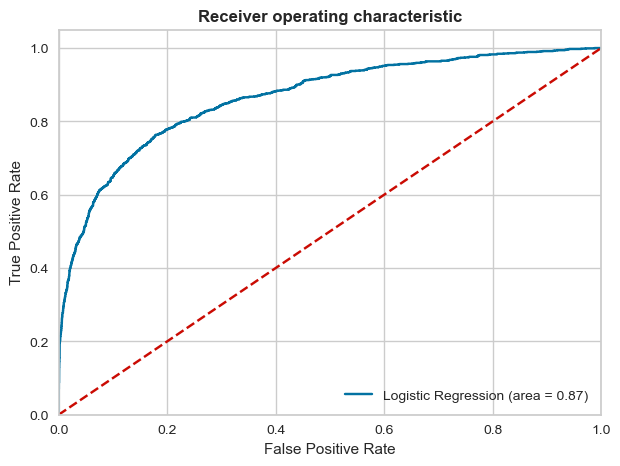

In [30]:
logit_roc_auc_train = roc_auc_score(y_train, logit_model3.predict(X_train2_with_intercept))
fpr, tpr, thresholds = roc_curve(y_train, logit_model3.predict(X_train2_with_intercept))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic",fontweight='bold')
plt.legend(loc="lower right")
plt.show()

**Checking Precision-Recall curve to see if we can find a better threshold**

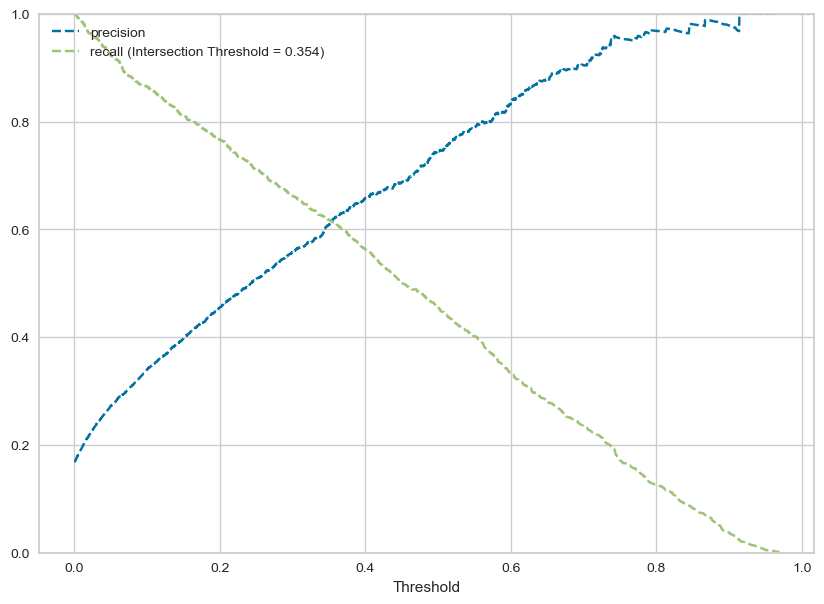

In [31]:
y_scores = logit_model3.predict(X_train2_with_intercept)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    intersection_idx = np.argmin(np.abs(prec - rec))
    intersection_threshold = tre[intersection_idx]
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label=f"recall (Intersection Threshold = {intersection_threshold:.3f})")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [32]:
print("Threshold where Precision ~ Recall:", 0.354)

Threshold where Precision ~ Recall: 0.354


At threshold around 0.35 we will get equal precision and recall but taking a step back and selecting value around 0.30 will provide a higher recall and a good precision.

**Logistic Regression - Performance Metrics with Best Threshold**

In [33]:
optimal_threshold_curve = 0.3

df_log_reg_train = model_performance_classification_statsmodels(logit_model3, X_train2_with_intercept, y_train, threshold=optimal_threshold_curve)
df_log_reg_train

,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC
0,LogisticRegression(statsmodel),0.854704,0.66145,0.558026,0.605352,0.865096


**Logistic Regression - Confusion Matrix with Best Threshold**

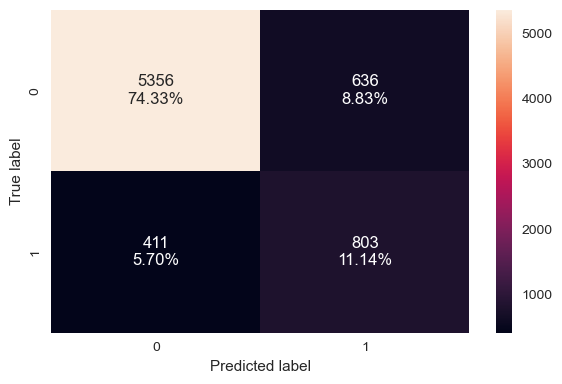

In [34]:
confusion_matrix_statsmodels(logit_model3, X_train2_with_intercept, y_train,threshold = optimal_threshold_curve)

##### **Checking Logistic Regression model performance on the Validation set**

In [35]:

X_val_with_intercept = X_val_cleaned.copy()
X_val_with_intercept = sm.add_constant(X_val_with_intercept)
X_val_with_intercept = X_val_with_intercept[selected_features]

**Logistic Regression - Performance Metrics**

In [36]:
df_log_reg_val = model_performance_classification_statsmodels(logit_model3, X_val_with_intercept, y_val,threshold=optimal_threshold_curve)
df_log_reg_val

,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC
0,LogisticRegression(statsmodel),0.846837,0.669967,0.53562,0.595308,0.863944


**Logistic Regression - Confusion Matrix**

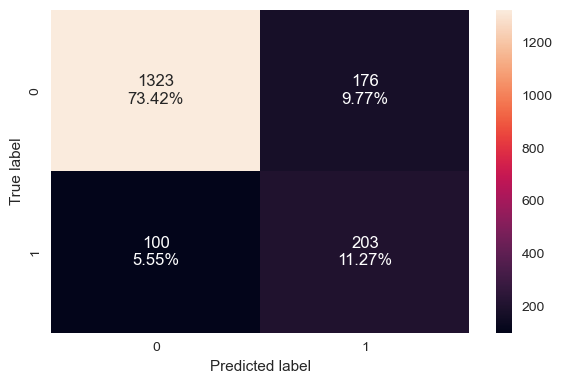

In [37]:
confusion_matrix_statsmodels(logit_model3, X_val_with_intercept, y_val,threshold=optimal_threshold_curve)

**Logistic Regression - ROC-AUC Curve**

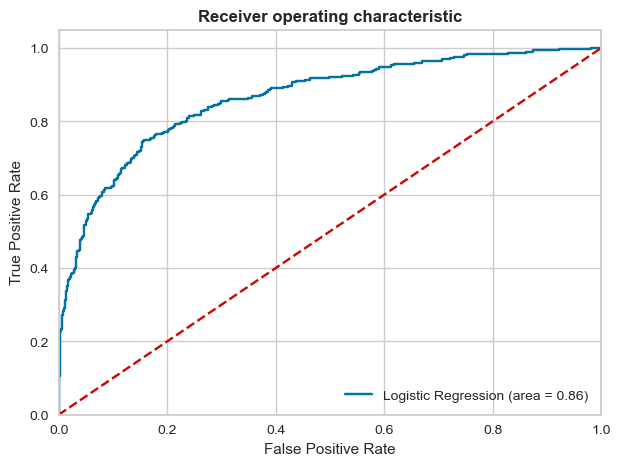

In [38]:
logit_roc_auc_train = roc_auc_score(y_val, logit_model3.predict(X_val_with_intercept))
fpr, tpr, thresholds = roc_curve(y_val, logit_model3.predict(X_val_with_intercept))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic",fontweight='bold')
plt.legend(loc="lower right")
plt.show()

#### **Initial Model Building (Other Models)**

##### **Checking various Models performance on the Training set**

In [39]:

models = []  # Empty list to store all the models

# Appending models into the list
# models.append(("LogisticRegression", LogisticRegression(random_state=42)))
models.append(("DecisionTree", DecisionTreeClassifier(random_state=42, class_weight='balanced')))
models.append(("SVM", SVC(random_state=42, kernel='linear',probability=True,class_weight='balanced')))
models.append(("RandomForest", RandomForestClassifier(random_state=42, class_weight='balanced')))
models.append(("AdaBoost", AdaBoostClassifier(random_state=42)))
models.append(("GBM", GradientBoostingClassifier(random_state=42)))
models.append(("XGBoost", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')))

perf_metrics_list = ['Model','Accuracy','Precision','Recall','F1-Score','ROC-AUC']
train_performance_metrics_df = pd.DataFrame(columns = perf_metrics_list)

for name, model in models:
    model.fit(X_train_cleaned, y_train)
    y_pred_proba = model.predict_proba(X_train_cleaned)[:, 1]
    acc_train = accuracy_score(y_train, model.predict(X_train_cleaned))
    pre_train = precision_score(y_train, model.predict(X_train_cleaned))
    rec_train = recall_score(y_train, model.predict(X_train_cleaned))
    f1_train = f1_score(y_train, model.predict(X_train_cleaned))
    auc_train = roc_auc_score(y_train, y_pred_proba)
    new_row_train = pd.DataFrame([{'Model':name,'Accuracy':acc_train,'Precision':pre_train,'Recall':rec_train,'F1-Score':f1_train, 'ROC-AUC':auc_train}])
    train_performance_metrics_df = pd.concat([train_performance_metrics_df,new_row_train], axis =0, ignore_index=True)
    train_performance_metrics_df

pd.concat([train_performance_metrics_df,df_log_reg_train],axis = 0,ignore_index=True)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,DecisionTree,1.000000,1.000000,1.000000,1.000000,1.000000
1,SVM,0.796281,0.441690,0.792422,0.567217,0.869773
2,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000
3,AdaBoost,0.889259,0.747031,0.518122,0.611868,0.888891
4,GBM,0.913128,0.849169,0.588962,0.695525,0.942098
5,XGBoost,0.999445,1.000000,0.996705,0.998350,1.000000
6,LogisticRegression(statsmodel),0.854704,0.558026,0.661450,0.605352,0.865096


##### **Checking various Models performance on the Validation set**

In [40]:

val_performance_metrics_df = pd.DataFrame(columns = perf_metrics_list)

for name, model in models:
    y_val_pred = model.predict(X_val_cleaned)
    y_pred_proba = model.predict_proba(X_val_cleaned)[:, 1]
    acc_val = accuracy_score(y_val, y_val_pred)
    pre_val = precision_score(y_val, y_val_pred)
    rec_val = recall_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)
    auc_val = roc_auc_score(y_val, y_pred_proba)
    new_row_val = pd.DataFrame([{'Model':name,'Accuracy':acc_val,'Precision':pre_val,'Recall':rec_val,'F1-Score':f1_val, 'ROC-AUC':auc_val}])
    val_performance_metrics_df = pd.concat([val_performance_metrics_df,new_row_val], axis =0, ignore_index=True)

pd.concat([val_performance_metrics_df,df_log_reg_train],axis = 0, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,DecisionTree,0.920644,0.751572,0.788779,0.769726,0.868039
1,SVM,0.801332,0.448211,0.785479,0.570743,0.868189
2,RandomForest,0.958380,0.983051,0.765677,0.860853,0.991365
3,AdaBoost,0.883463,0.704846,0.528053,0.603774,0.889043
4,GBM,0.897336,0.775701,0.547855,0.642166,0.927184
5,XGBoost,0.954495,0.907749,0.811881,0.857143,0.986021
6,LogisticRegression(statsmodel),0.854704,0.558026,0.661450,0.605352,0.865096


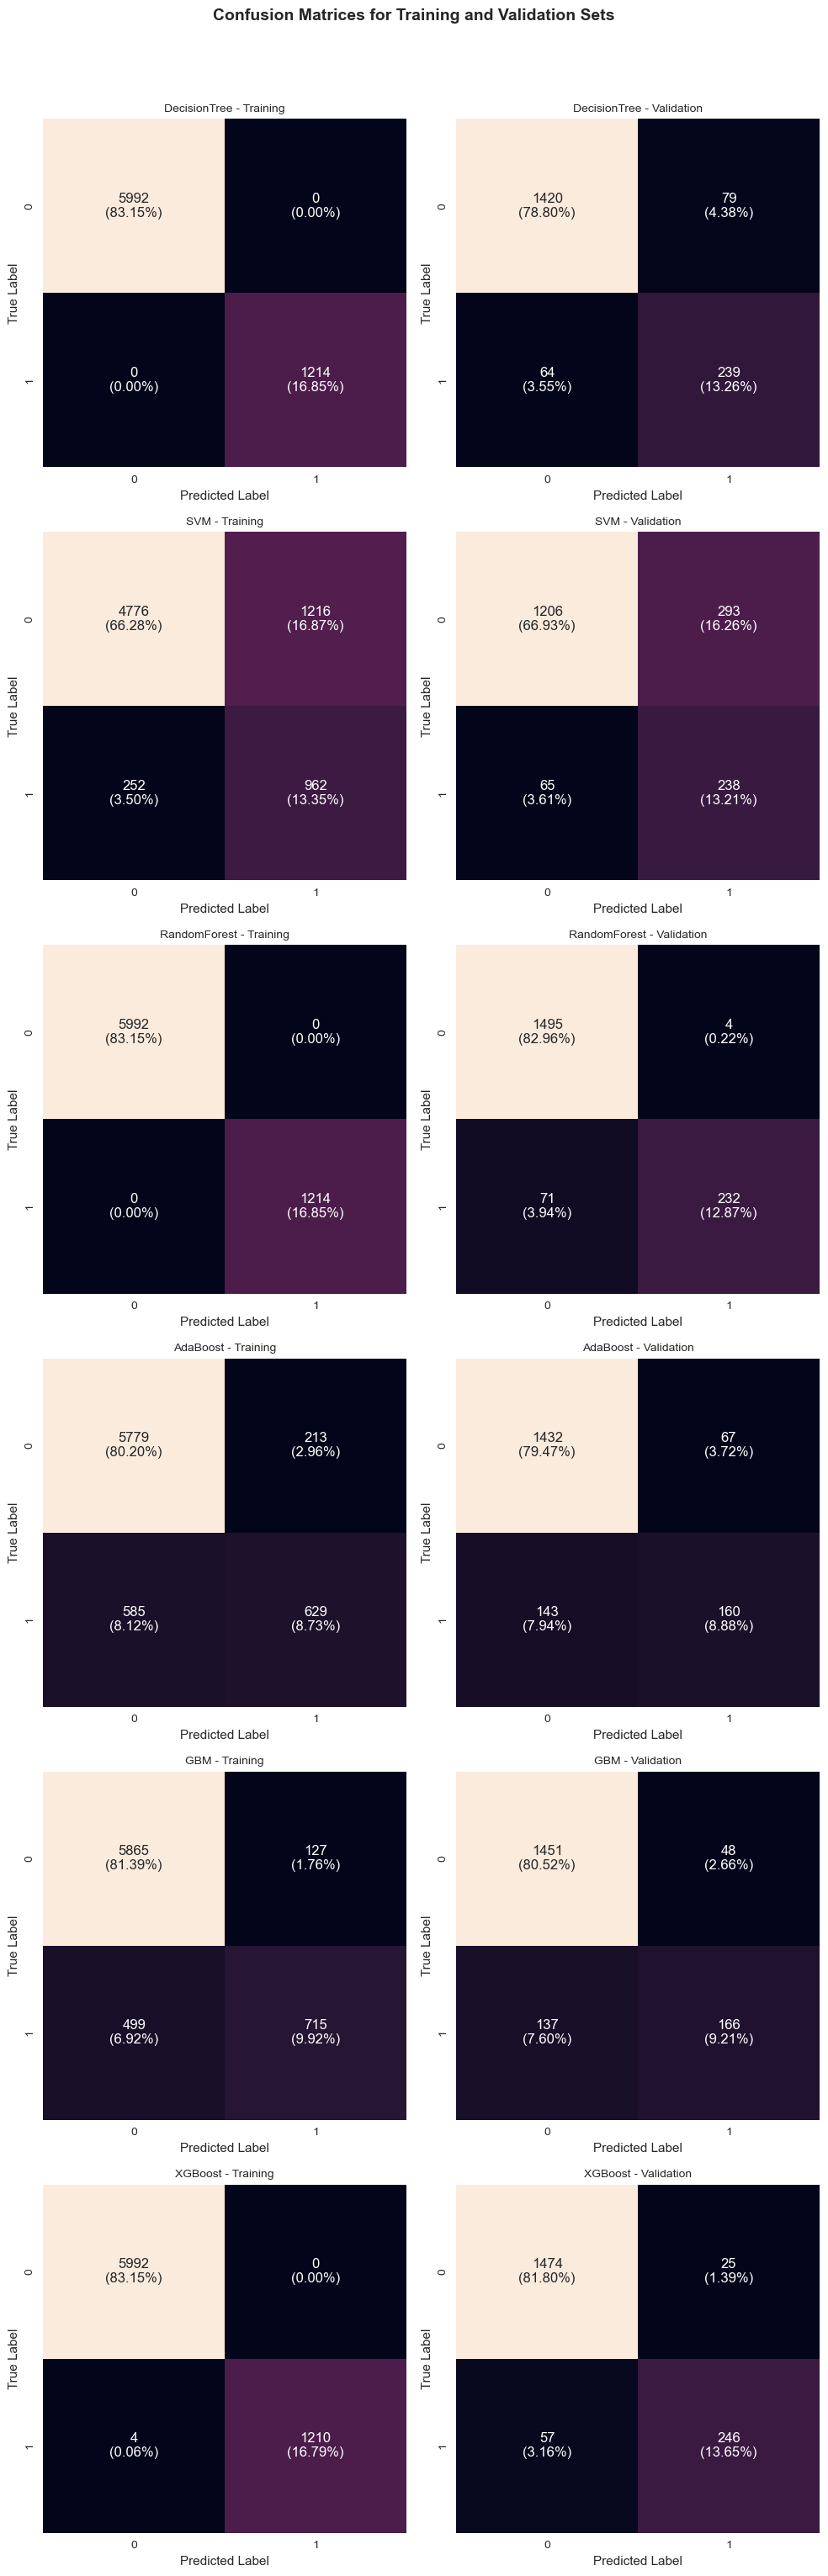

In [41]:

fig, axes = plt.subplots(len(models), 2, figsize=(10, 5 * len(models)))  # Dynamic height
fig.suptitle("Confusion Matrices for Training and Validation Sets", fontsize=14, fontweight='bold', y=1.02)

# Iterate through models and axes
for idx, (name, model) in enumerate(models):
    # Training set
    confusion_matrix_sklearn(axes[idx, 0], model, X_train_cleaned, y_train, f"{name} - Training")
    
    # Validation set
    confusion_matrix_sklearn(axes[idx, 1], model, X_val_cleaned, y_val, f"{name} - Validation")

plt.tight_layout()
plt.show()

##### **Performance Comparison for All the Models**

In [42]:
comp_performance_metrics_df = pd.DataFrame(columns = ['Model','Training Score','Validation Score','Difference'])
for name, model in models:
    rec_train = recall_score(y_train, model.predict(X_train_cleaned))
    rec_val = recall_score(y_val, model.predict(X_val_cleaned))
    diff = rec_train - rec_val

    new_row = pd.DataFrame([{'Model':name,'Training Score':rec_train,'Validation Score':rec_val,'Difference':diff}])
    comp_performance_metrics_df = pd.concat([comp_performance_metrics_df,new_row], axis =0, ignore_index=True)

lr_rec_train = df_log_reg_train['Recall'][0]
lr_rec_val = df_log_reg_val['Recall'][0]
lr_diff = lr_rec_train - lr_rec_val
lr_model_perf = pd.DataFrame([{'Model':df_log_reg_train['Model'][0],'Training Score':lr_rec_train,'Validation Score':lr_rec_val,'Difference':lr_diff}])
comp_performance_metrics_df = pd.concat([comp_performance_metrics_df,lr_model_perf], axis =0, ignore_index=True)

comp_performance_metrics_df.sort_values(by = 'Difference',ascending = False)


,Model,Training Score,Validation Score,Difference
2,RandomForest,1.000000,0.765677,0.234323
0,DecisionTree,1.000000,0.788779,0.211221
5,XGBoost,0.996705,0.811881,0.184824
4,GBM,0.588962,0.547855,0.041107
1,SVM,0.792422,0.785479,0.006943
6,LogisticRegression(statsmodel),0.661450,0.669967,-0.008517
3,AdaBoost,0.518122,0.528053,-0.009931


From the above results:

- XGBoost shows the best validation performance (0.8118) while maintaining relatively good generalization (difference of 0.185), but it still shows some overfitting tendency.
- DecisionTree and RandomForest have near-perfect training scores (Accuracy, Precision, Recall, and F1-score all close to 1). However, their validation recall scores drop significantly (e.g., DecisionTree from 1.00 → 0.788 and RandomForest from 1.00 → 0.766), indicating potential overfitting.
- Out of all these, SVM shows excellent consistency between training and validation (difference < 0.01)
- AdaBoost and GBM have relatively smaller gaps between training and validation scores, indicating better generalization. But the recall scores for these are near to 0.50 which will cause random predictions.
- Comparatively, GBM has a reasonable validation recall (0.5479) and a moderate training score (0.5889), showing a balance between learning and avoiding overfitting.

In churn prediction, recall is critical as we need to minimize false negatives (missed churn cases).
Models with high recall and low overfitting risk are preferable.

#### **Recommended Models for Further Tuning:**

- **Primary Choice:** XGBoost (best validation performance)

- **Secondary Choice:** SVM (most stable performance)

- **XGBoost**

    - High recall on training data (0.9967) but a notable drop in validation (0.8118).
    - Still performs better than DecisionTree/RandomForest in validation.
    - With proper regularization (tree depth, learning rate tuning), it can be optimized.

- **Support Vector Machine (SVM)**

    - Balanced training-validation recall (0.792422 → 0.785479).
    - Less prone to overfitting compared to DecisionTree/RandomForest.
    - Can improve with hyperparameter tuning (e.g., learning rate, number of estimators).


**Final Recommendation**
Fr customer churn prediction:

- We will focus on XGB and SVM for its balance and generalization ability. And we will consider XGB if tuned properly to reduce overfitting.

#### **Model Interpretation**


Now let's interpret the best-performing models using feature importance

In [43]:
XGB_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
XGB_model.fit(X_train_cleaned, y_train)
importances = XGB_model.feature_importances_
xgb_feature_importance_df = pd.DataFrame({'Feature': X_train_cleaned.columns, 'Importance': importances})
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)
xgb_feature_importance_df

,Feature,Importance
12,Tenure_Group,0.229290
22,Complain_ly_1.0,0.109944
5,CC_Agent_Score,0.046421
19,Marital_Status_Single,0.045495
4,account_segment,0.044980
0,City_Tier,0.043070
20,Login_device_Mobile,0.039551
15,Payment_UPI,0.038953
9,Day_Since_CC_connect,0.036227
16,Payment_Wallet,0.035670


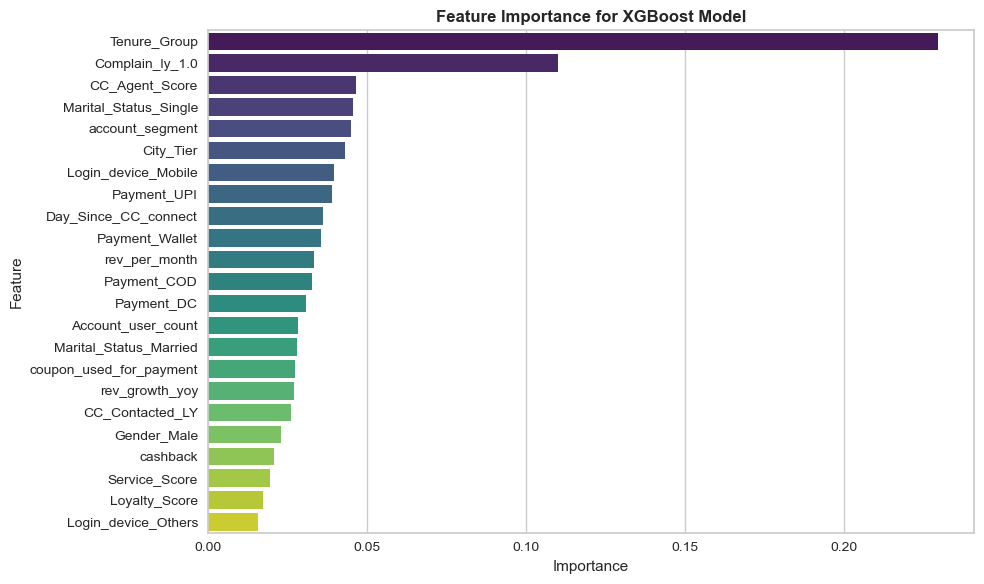

In [44]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance_df, palette = 'viridis')
plt.title('Feature Importance for XGBoost Model',fontweight = 'bold')
plt.tight_layout()
plt.show()

**Top 5 Most Important Features:**
- **Tenure_Group**: Customer tenure is the most influential factor in predicting churn. This suggests that how long a customer has been associated with the company significantly impacts churn probability.
- **Complain_ly_1.0**: Customers who complained in the last year are highly likely to churn, indicating dissatisfaction.
- **CC_Agent_Score**: The quality of customer care interactions (e.g., service ratings) plays a critical role in retention.
- **Marital_Status_Single**: Single customers may have a higher churn rate compared to married ones.
- **account_segment**: Account segment is also an important factor in predicting churn.

### **Model Building on Resampled Data (Build Various Models)**

#### **Applying SMOTE for Oversampling the Training data**

In [45]:
print(f"Before Oversampling, counts of label 'Yes': {sum(y_train == 1)}")
print(f"Before Oversampling, counts of label 'No': {sum(y_train == 0)}")

smote = SMOTE(sampling_strategy=1, k_neighbors=5, random_state = 42)  # Synthetic Minority Over Sampling Technique

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cleaned, y_train)
print(f"After Oversampling, counts of label 'Yes': {sum(y_train_resampled == 1)}")
print(f"After Oversampling, counts of label 'No': {sum(y_train_resampled == 0)}")

print(f"After Oversampling, the shape of train_X: {X_train_resampled.shape}")
print(f"After Oversampling, the shape of train_y: {y_train_resampled.shape}")

Before Oversampling, counts of label 'Yes': 1214
Before Oversampling, counts of label 'No': 5992
After Oversampling, counts of label 'Yes': 5992
After Oversampling, counts of label 'No': 5992
After Oversampling, the shape of train_X: (11984, 23)
After Oversampling, the shape of train_y: (11984,)


#### **Building Logistic Regression after SMOTE**

For the next round of VIF (Multicollinearity Check) after applying SMOTE, we should use the resampled dataset but only with the initially selected significant features.


In [46]:
selected_features.remove('const')
X_train_resampled_with_intercept = X_train_resampled[selected_features]

print(f'\033[1mNo. of Features in updated Train dataset: {len(X_train_resampled_with_intercept.columns)}\033[0m\n')

No. of Features in updated Train dataset: 18



In [47]:
X_train_resampled_with_intercept = sm.add_constant(X_train_resampled_with_intercept)
# Fit the logistic regression model
logit_model4 = sm.Logit(y_train_resampled, X_train_resampled_with_intercept).fit()

# Print summary
print(logit_model4.summary())

Optimization terminated successfully.
         Current function value: 0.452652
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                11984
Model:                          Logit   Df Residuals:                    11965
Method:                           MLE   Df Model:                           18
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.3470
Time:                        19:52:53   Log-Likelihood:                -5424.6
converged:                       True   LL-Null:                       -8306.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.8850      0.030    -29.973      0.000      -0.943   

##### **Multi Collinearity Check for Each features after SMOTE**

In [48]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_resampled_with_intercept.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_resampled_with_intercept.values, i) for i in range(X_train_resampled_with_intercept.shape[1])]
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
9,Day_Since_CC_connect,1.408148
13,Payment_Wallet,1.390741
1,City_Tier,1.379222
10,cashback,1.379155
8,coupon_used_for_payment,1.293285
11,Tenure_Group,1.232902
0,const,1.174913
16,Login_device_Mobile,1.126745
17,Login_device_Others,1.120814
3,Account_user_count,1.056922


So there are no features with VIF >5 indicating there is no Multicollinearity observed in the resampled data.

Also there are no features in the result summary with p value > 0.05. 

##### **Coefficient Interpretation for Each features after SMOTE**

In [49]:
# converting coefficients to odds
odds = np.exp(logit_model4.params)

# finding the percentage change
perc_change_odds = (np.exp(logit_model4.params) - 1) * 100

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train_resampled_with_intercept.columns)

,Odds,Change_odd%
const,0.412716,-58.728366
City_Tier,1.327858,32.785786
CC_Contacted_LY,1.275843,27.584348
Account_user_count,1.305727,30.572746
account_segment,0.591032,-40.896794
CC_Agent_Score,1.446780,44.678011
rev_per_month,1.372226,37.222649
rev_growth_yoy,0.847944,-15.205558
coupon_used_for_payment,1.392597,39.259734
Day_Since_CC_connect,0.685276,-31.472398


##### **Checking Logistic Regression model performance on the training set after SMOTE**


**Logistic Regression - Performance Metrics**

In [50]:
model_performance_classification_statsmodels(logit_model4, X_train_resampled_with_intercept, y_train_resampled)

,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC
0,LogisticRegression(statsmodel),0.796646,0.812083,0.787761,0.799737,0.870985


**Logistic Regression - Confusion Matrix**

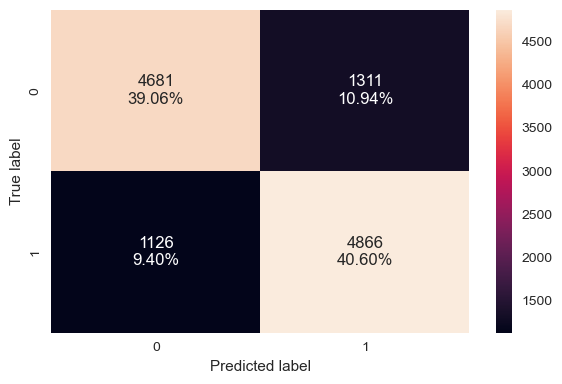

In [51]:
confusion_matrix_statsmodels(logit_model4, X_train_resampled_with_intercept, y_train_resampled)

**Logistic Regression - ROC-AUC Curve**

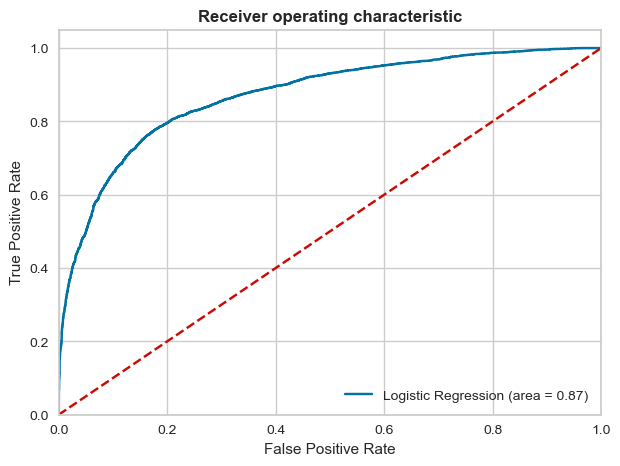

In [52]:
logit_roc_auc_train = roc_auc_score(y_train_resampled, logit_model4.predict(X_train_resampled_with_intercept))
fpr, tpr, thresholds = roc_curve(y_train_resampled, logit_model4.predict(X_train_resampled_with_intercept))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic",fontweight='bold')
plt.legend(loc="lower right")
plt.show()

**Finding Optimal threshold from ROC-AUC Curve**

In [53]:

# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train_resampled, logit_model4.predict(X_train_resampled_with_intercept))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.5434449373207351


**Logistic Regression - Performance Metrics after SMOTE with Optimal Threshold**

In [54]:
model_performance_classification_statsmodels(logit_model4, X_train_resampled_with_intercept, y_train_resampled, threshold=optimal_threshold_auc_roc)

,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC
0,LogisticRegression(statsmodel),0.800067,0.785214,0.809254,0.797052,0.870985


**Logistic Regression - Confusion Matrix after SMOTE with Optimal Threshold**

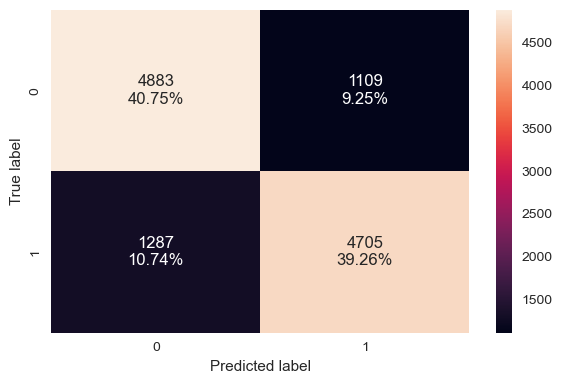

In [55]:
confusion_matrix_statsmodels(logit_model4, X_train_resampled_with_intercept, y_train_resampled,threshold = optimal_threshold_auc_roc)

**Logistic Regression - ROC-AUC Curve after SMOTE with Optimal Threshold**

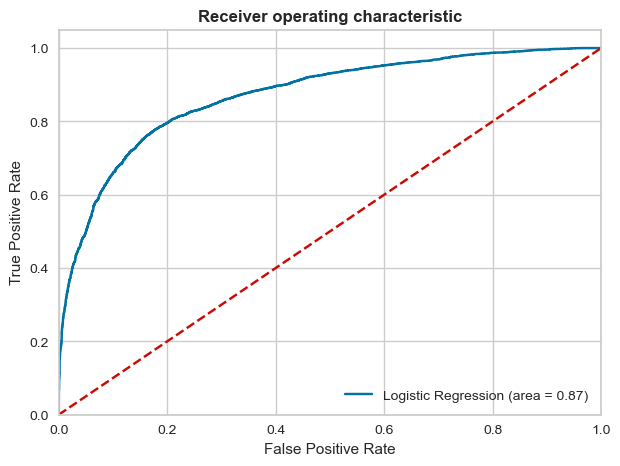

In [56]:
logit_roc_auc_train = roc_auc_score(y_train_resampled, logit_model4.predict(X_train_resampled_with_intercept))
fpr, tpr, thresholds = roc_curve(y_train_resampled, logit_model4.predict(X_train_resampled_with_intercept))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic",fontweight='bold')
plt.legend(loc="lower right")
plt.show()

**Checking Precision-Recall curve to see if we can find a better threshold**

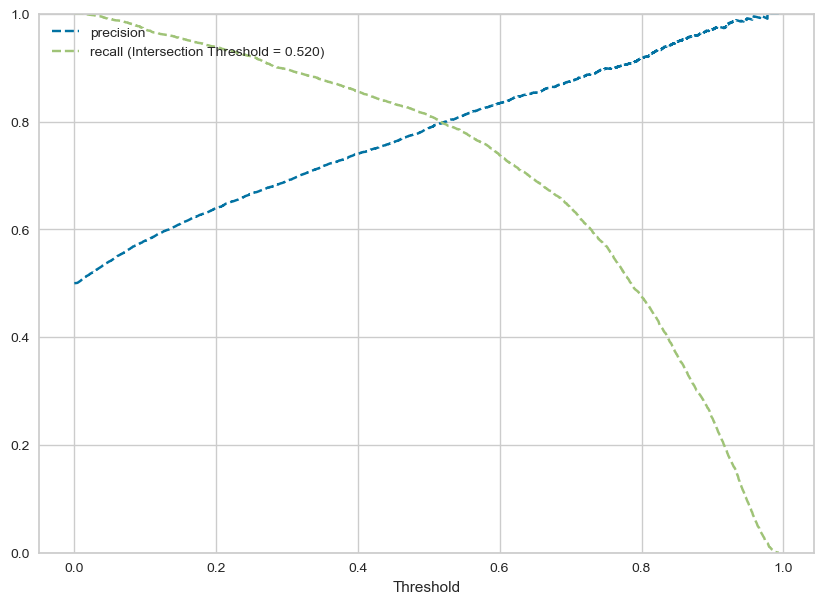

In [57]:

y_scores = logit_model4.predict(X_train_resampled_with_intercept)
prec, rec, tre = precision_recall_curve(y_train_resampled, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    intersection_idx = np.argmin(np.abs(prec - rec))
    intersection_threshold = tre[intersection_idx]
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label=f"recall (Intersection Threshold = {intersection_threshold:.3f})")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [58]:
print("Threshold where Precision ~ Recall:", 0.520)

Threshold where Precision ~ Recall: 0.52


At threshold around 0.520 we will get equal precision and recall but taking a step back and selecting value around 0.50 will provide a higher recall and a good precision.


**Logistic Regression - Performance Metrics after SMOTE with Best Threshold**

In [59]:
optimal_threshold_curve = 0.5

df_log_reg_train = model_performance_classification_statsmodels(logit_model4, X_train_resampled_with_intercept, y_train_resampled, threshold=optimal_threshold_curve)
df_log_reg_train

,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC
0,LogisticRegression(statsmodel),0.796646,0.812083,0.787761,0.799737,0.870985


**Logistic Regression - Confusion Matrix after SMOTE with Best Threshold**

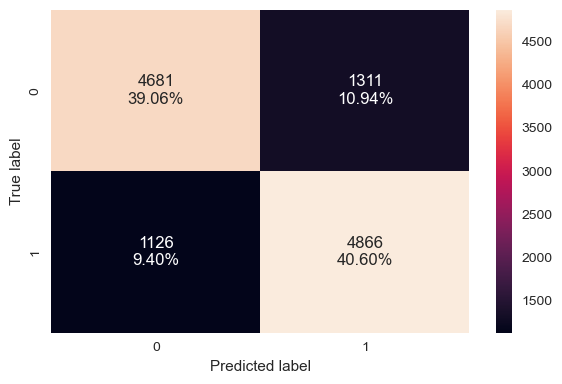

In [60]:
confusion_matrix_statsmodels(logit_model4, X_train_resampled_with_intercept, y_train_resampled, threshold=optimal_threshold_curve)

##### **Checking Logistic Regression model performance after SMOTE on the Validation set**

In [61]:
X_val_with_intercept = X_val_cleaned.copy()
X_val_with_intercept = X_val_with_intercept[selected_features]
X_val_with_intercept = sm.add_constant(X_val_with_intercept)

**Logistic Regression - Performance Metrics**


In [62]:
df_log_reg_val = model_performance_classification_statsmodels(logit_model4, X_val_with_intercept, y_val,threshold=optimal_threshold_curve)
df_log_reg_val


,Model,Accuracy,Recall,Precision,F1-Score,ROC-AUC
0,LogisticRegression(statsmodel),0.786349,0.805281,0.42807,0.558992,0.865688


**Logistic Regression - Confusion Matrix**


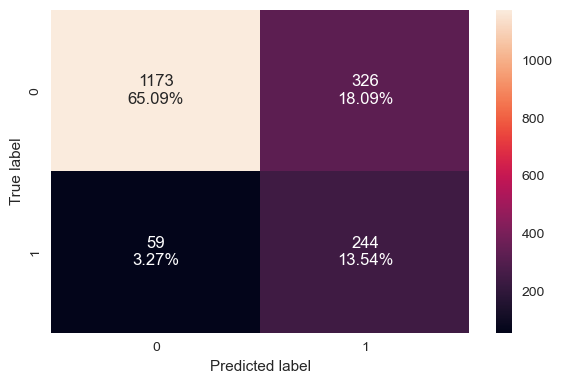

In [63]:
confusion_matrix_statsmodels(logit_model4, X_val_with_intercept, y_val,threshold=optimal_threshold_curve)


**Logistic Regression - ROC-AUC Curve**


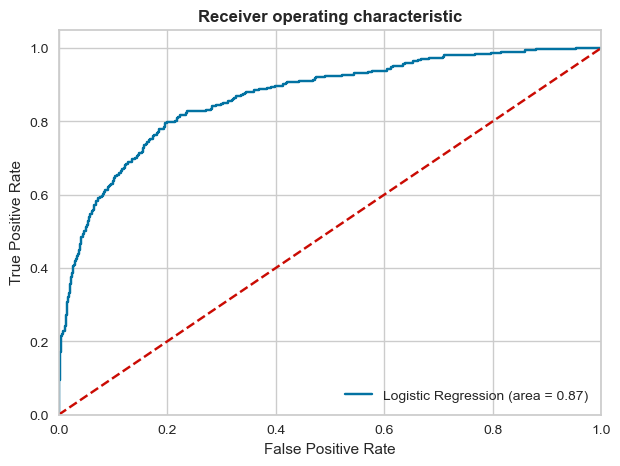

In [64]:
logit_roc_auc_val = roc_auc_score(y_val, logit_model4.predict(X_val_with_intercept))
fpr, tpr, thresholds = roc_curve(y_val, logit_model4.predict(X_val_with_intercept))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_val)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic",fontweight='bold')
plt.legend(loc="lower right")
plt.show()

#### **Building other models after SMOTE**

##### **Checking various Models performance with SMOTE on the Training set**

In [65]:
models = []  # Empty list to store all the models

# Appending models into the list
# models.append(("LogisticRegression", LogisticRegression(random_state=42)))
models.append(("DecisionTree", DecisionTreeClassifier(random_state=42, class_weight='balanced')))
models.append(("SVM", SVC(random_state=42, kernel='linear',probability=True,class_weight='balanced')))
models.append(("RandomForest", RandomForestClassifier(random_state=42, class_weight='balanced')))
models.append(("AdaBoost", AdaBoostClassifier(random_state=42)))
models.append(("GBM", GradientBoostingClassifier(random_state=42)))
models.append(("XGBoost", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')))

perf_metrics_list = ['Model','Accuracy','Precision','Recall','F1-Score','ROC-AUC']
train_performance_metrics_df = pd.DataFrame(columns = perf_metrics_list)

for name, model in models:
    model.fit(X_train_resampled, y_train_resampled)
    y_pred_proba = model.predict_proba(X_train_resampled)[:, 1]
    acc_train = accuracy_score(y_train_resampled, model.predict(X_train_resampled))
    pre_train = precision_score(y_train_resampled, model.predict(X_train_resampled))
    rec_train = recall_score(y_train_resampled, model.predict(X_train_resampled))
    f1_train = f1_score(y_train_resampled, model.predict(X_train_resampled))
    auc_train = roc_auc_score(y_train_resampled, y_pred_proba)
    new_row_train = pd.DataFrame([{'Model':name,'Accuracy':acc_train,'Precision':pre_train,'Recall':rec_train,'F1-Score':f1_train, 'ROC-AUC':auc_train}])
    train_performance_metrics_df = pd.concat([train_performance_metrics_df,new_row_train], axis =0, ignore_index=True)
    train_performance_metrics_df

pd.concat([train_performance_metrics_df,df_log_reg_train],axis = 0,ignore_index=True)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,DecisionTree,1.000000,1.000000,1.000000,1.000000,1.000000
1,SVM,0.804322,0.801554,0.808912,0.805216,0.878351
2,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000
3,AdaBoost,0.875167,0.878962,0.870160,0.874539,0.947459
4,GBM,0.927654,0.934248,0.920060,0.927100,0.979072
5,XGBoost,0.999666,1.000000,0.999332,0.999666,0.999998
6,LogisticRegression(statsmodel),0.796646,0.787761,0.812083,0.799737,0.870985


##### **Checking various Models performance with SMOTE on the Validation set**

In [66]:
val_performance_metrics_df = pd.DataFrame(columns = perf_metrics_list)

for name, model in models:
    y_val_pred = model.predict(X_val_cleaned)
    y_pred_proba = model.predict_proba(X_val_cleaned)[:, 1]
    acc_val = accuracy_score(y_val, y_val_pred)
    pre_val = precision_score(y_val, y_val_pred)
    rec_val = recall_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)
    auc_val = roc_auc_score(y_val, y_pred_proba)
    new_row_val = pd.DataFrame([{'Model':name,'Accuracy':acc_val,'Precision':pre_val,'Recall':rec_val,'F1-Score':f1_val, 'ROC-AUC':auc_val}])
    val_performance_metrics_df = pd.concat([val_performance_metrics_df,new_row_val], axis =0, ignore_index=True)

pd.concat([val_performance_metrics_df,df_log_reg_train],axis = 0, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,DecisionTree,0.909545,0.708333,0.785479,0.744914,0.860051
1,SVM,0.801887,0.449057,0.785479,0.571429,0.868900
2,RandomForest,0.958380,0.895833,0.851485,0.873096,0.986667
3,AdaBoost,0.846282,0.530374,0.749175,0.621067,0.884551
4,GBM,0.885683,0.645646,0.709571,0.676101,0.916926
5,XGBoost,0.955605,0.885813,0.844884,0.864865,0.983593
6,LogisticRegression(statsmodel),0.796646,0.787761,0.812083,0.799737,0.870985


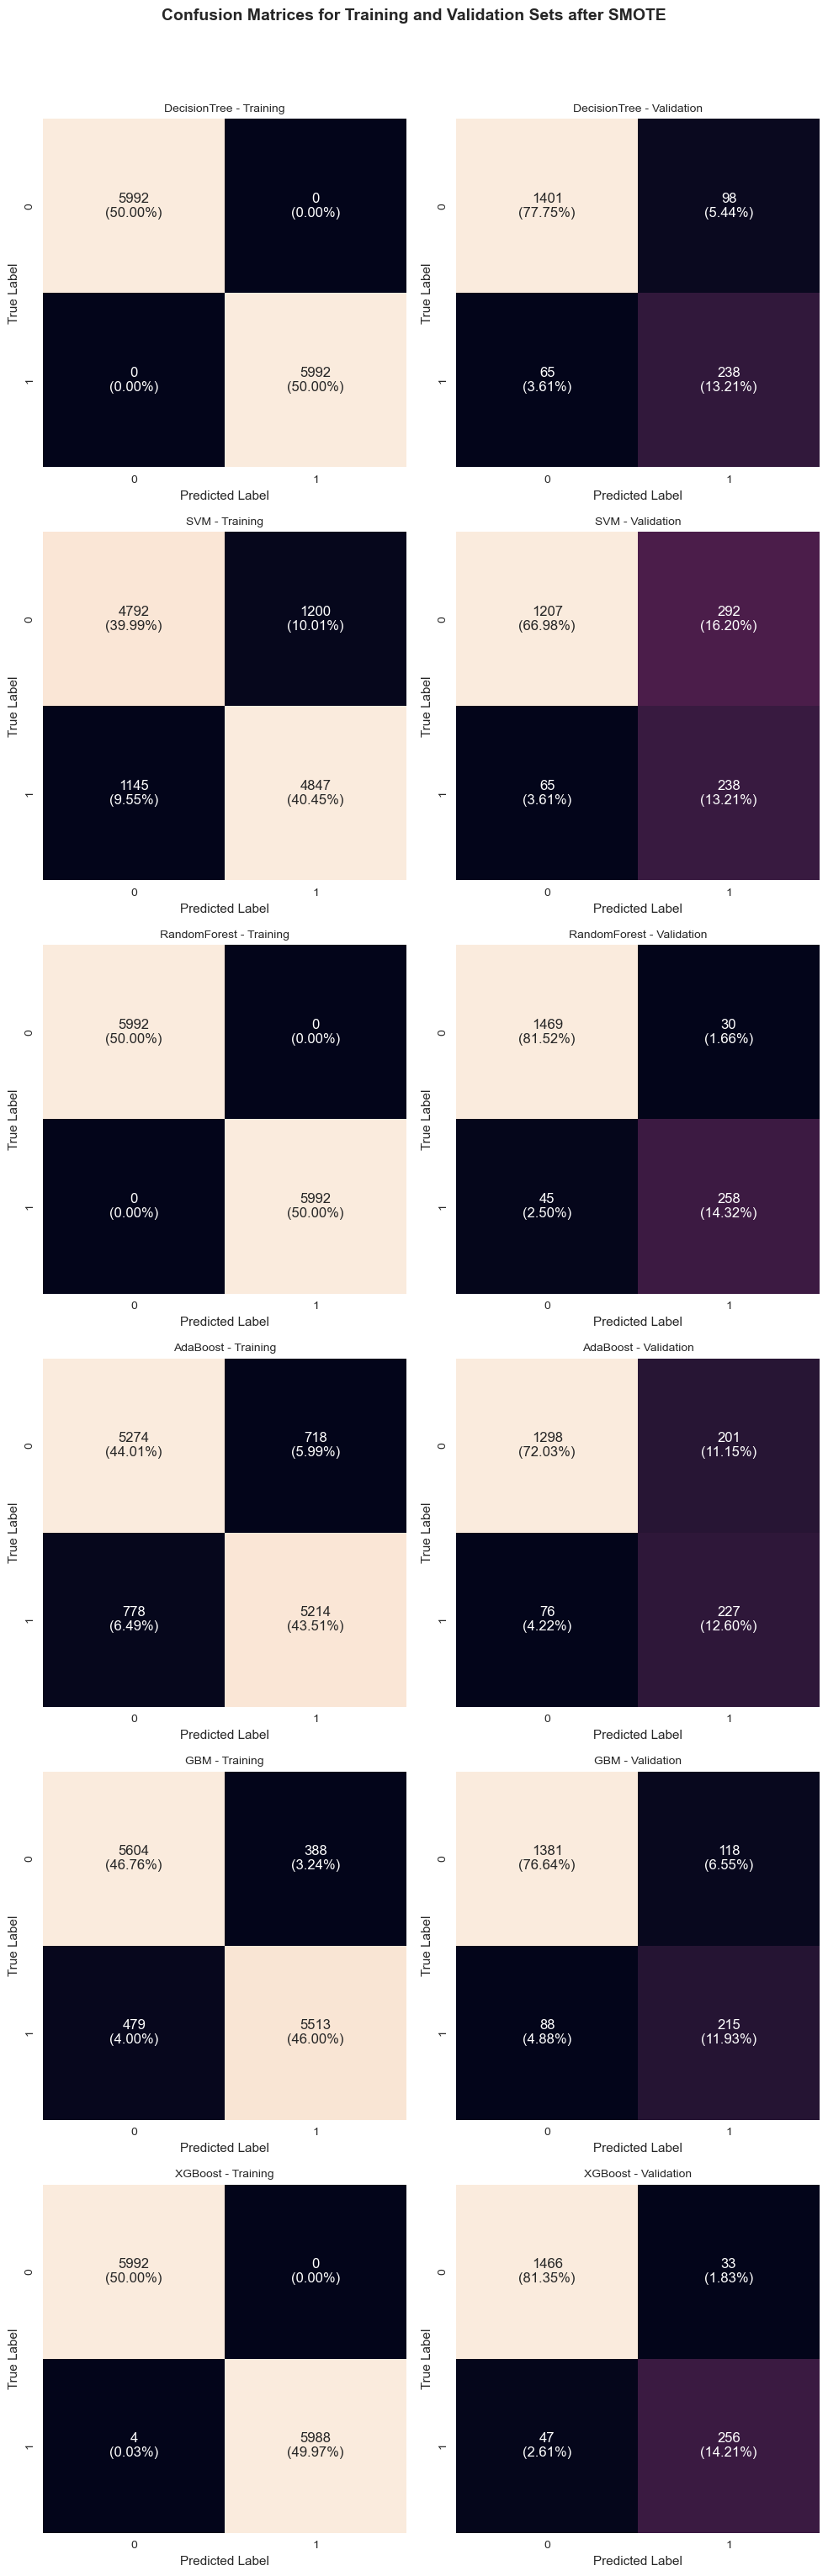

In [67]:
fig, axes = plt.subplots(len(models), 2, figsize=(10, 5 * len(models)))  # Dynamic height
fig.suptitle("Confusion Matrices for Training and Validation Sets after SMOTE", fontsize=14, fontweight='bold', y=1.02)

# Iterate through models and axes
for idx, (name, model) in enumerate(models):
    # Training set
    confusion_matrix_sklearn(axes[idx, 0], model, X_train_resampled, y_train_resampled, f"{name} - Training")
    
    # Validation set
    confusion_matrix_sklearn(axes[idx, 1], model, X_val_cleaned, y_val, f"{name} - Validation")

plt.tight_layout()
plt.show()

##### **Performance Comparison for All the Models after SMOTE**

In [68]:
comp_performance_metrics_df = pd.DataFrame(columns = ['Model','Training Score','Validation Score','Difference'])
for name, model in models:
    rec_train = recall_score(y_train_resampled, model.predict(X_train_resampled))
    rec_val = recall_score(y_val, model.predict(X_val_cleaned))
    diff = rec_train - rec_val

    new_row = pd.DataFrame([{'Model':name,'Training Score':rec_train,'Validation Score':rec_val,'Difference':diff}])
    comp_performance_metrics_df = pd.concat([comp_performance_metrics_df,new_row], axis =0, ignore_index=True)

lr_rec_train = df_log_reg_train['Recall'][0]
lr_rec_val = df_log_reg_val['Recall'][0]
lr_diff = lr_rec_train - lr_rec_val
lr_model_perf = pd.DataFrame([{'Model':df_log_reg_train['Model'][0],'Training Score':lr_rec_train,'Validation Score':lr_rec_val,'Difference':lr_diff}])
comp_performance_metrics_df = pd.concat([comp_performance_metrics_df,lr_model_perf], axis =0, ignore_index=True)

comp_performance_metrics_df.sort_values(by = 'Difference',ascending = False)


,Model,Training Score,Validation Score,Difference
0,DecisionTree,1.000000,0.785479,0.214521
4,GBM,0.920060,0.709571,0.210489
5,XGBoost,0.999332,0.844884,0.154448
2,RandomForest,1.000000,0.851485,0.148515
3,AdaBoost,0.870160,0.749175,0.120985
1,SVM,0.808912,0.785479,0.023433
6,LogisticRegression(statsmodel),0.812083,0.805281,0.006802


**Before Oversampling**
- XGBoost (0.811881) and SVM (0.785479) have the highest validation scores. The differences between training and validation scores are small, indicating less overfitting.

**After Oversampling**
- **RandomForest (0.851485) and XGBoost (0.844884)** have the highest validation scores.
- RandomForest has better Generalization: It shows a smaller performance gap between training (1.000) and validation (0.851) compared to XGBoost (0.999 vs 0.845)
- Both models show more Balanced Metrics :
  - Recall: 0.851 (good at identifying churners)
  - Precision: 0.896 (not flagging too many non-churners)
- DecisionTree, RandomForest, and XGBoost have high training scores (1.000000 or close) but significantly lower validation scores, indicating overfitting.

So the best Trade-off is RandomForest and XGBoost show the best balance between training and validation performance.
- **Primary Model Choice: RandomForest**
- **Secondary Model Choice: XGBoost**

### **Hyperparameter Tuning**

In [69]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs','saga']
}

# Perform randomized search for LogisticRegression
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    param_distributions=param_dist_lr,
    n_iter=50,  # Number of parameter settings to sample
    scoring='recall',  # Use recall for imbalanced datasets
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # For reproducibility
)

random_search_lr.fit(X_train_resampled, y_train_resampled)

# Best parameters for LogisticRegression
print("Best Parameters for LogisticRegression:", random_search_lr.best_params_)
print("Best Recall Score for LogisticRegression:", random_search_lr.best_score_)

Best Parameters for LogisticRegression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}
Best Recall Score for LogisticRegression: 0.818257702230991


#### **Recommendations for Hyperparameter Tuning**

**i.RandomForest**

- After oversampling, it has a decent validation score (0.851485).
- While it shows some overfitting (difference of 0.148515), it is one of the better-performing ensemble models.
- RandomForest is robust, handles non-linear data well, and provides feature importance.**

**ii. XGBoost**

- After oversampling, it has a good validation score (0.844884).
- While it shows some overfitting (difference of 0.154448), it is one of the best-performing boosting models.
- XGBoost is highly effective for structured/tabular data and provides excellent performance with proper tuning.

**iii. Logistic Regression :**
  
- After oversampling, it has the highest validation score (0.805281).
- The difference between training and validation scores is small (0.006802), indicating good generalization.
- Logistic Regression is simple, interpretable, and less prone to overfitting compared to complex models like Decision Trees or Random Forests.
         
**iv. SVM :**
  
- After oversampling, it has the second-highest validation score (0.785479).
- The difference between training and validation scores is moderate (0.023433), indicating reasonable generalization.
- SVM is effective for high-dimensional data and can handle non-linear decision boundaries using kernel functions.

#### **Tuning RandomForest Model**

In [70]:
# Define parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search for RandomForest
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42,class_weight='balanced'),
    param_distributions=param_grid_rf,
    n_iter=50,  # Number of parameter settings to sample
    scoring='recall',  # Use recall for imbalanced datasets
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # For reproducibility
)

random_search_rf.fit(X_train_resampled, y_train_resampled)

# Best parameters for RandomForest
print("Best Parameters for RandomForest:", random_search_rf.best_params_)
print("Best Recall Score for RandomForest:", random_search_rf.best_score_)

Best Parameters for RandomForest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Best Recall Score for RandomForest: 0.973957151271023


In [71]:
tuned_rf = RandomForestClassifier(**random_search_rf.best_params_)
tuned_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=30, max_features='log2')

**Checking Tuned RandomForest model's performance on Training set**

In [72]:
# Checking model's performance on training set
tuned_rf_train = model_performance_classification_sklearn(tuned_rf, X_train_resampled, y_train_resampled)
tuned_rf_train

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,1.0,1.0,1.0,1.0


**Checking Tuned RandomForest model's performance on Validation set**

In [73]:
# Checking model's performance on Validation set
tuned_rf_val = model_performance_classification_sklearn(tuned_rf, X_val_cleaned, y_val)
tuned_rf_val

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForestClassifier,0.95727,0.900709,0.838284,0.868376


#### **Tuning XGBoost Model**

In [74]:
print("XGBoost Version:", xgboost.__version__)
print("Scikit-learn Version:", sklearn.__version__)

XGBoost Version: 3.0.0
Scikit-learn Version: 1.6.1


In [75]:
# Define parameter distribution
param_dist_xgb = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0.1, 0.3, 0.5],  
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Perform RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    tree_method='hist'),
    param_distributions=param_dist_xgb,
    n_iter=20,  
    scoring='recall',
    cv=5,  
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit model
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# Output results
print("Best Parameters for XGBoost:", random_search_xgb.best_params_)
print("Best Recall Score for XGBoost:", random_search_xgb.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Recall Score for XGBoost: 0.9330569018979367


In [76]:
tuned_xgb = XGBClassifier(random_state=42, use_label_encoder=False, **random_search_xgb.best_params_)
tuned_xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

**Checking Tuned XGBoost model's performance on Training set**

In [77]:
# Checking model's performance on training set
tuned_xgb_train = model_performance_classification_sklearn(tuned_xgb, X_train_resampled, y_train_resampled)
tuned_xgb_train

,Model,Accuracy,Precision,Recall,F1-Score
0,XGBClassifier,0.977887,0.977648,0.978138,0.977893


**Checking Tuned XGBoost model's performance on Validation set**

In [78]:
# Checking model's performance on Validation set
tuned_xgb_val = model_performance_classification_sklearn(tuned_xgb, X_val_cleaned, y_val)
tuned_xgb_val

,Model,Accuracy,Precision,Recall,F1-Score
0,XGBClassifier,0.924528,0.761755,0.80198,0.78135


#### **Tuning LogisticRegression Model**

In [79]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs','saga']
}

# Perform randomized search for LogisticRegression
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, class_weight='balanced'),
    param_distributions=param_dist_lr,
    n_iter=50,  # Number of parameter settings to sample
    scoring='recall',  # Use recall for imbalanced datasets
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42  # For reproducibility
)

random_search_lr.fit(X_train_resampled, y_train_resampled)

# Best parameters for LogisticRegression
print("Best Parameters for LogisticRegression:", random_search_lr.best_params_)
print("Best Recall Score for LogisticRegression:", random_search_lr.best_score_)

Best Parameters for LogisticRegression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}
Best Recall Score for LogisticRegression: 0.818257702230991


In [80]:
tuned_lr = LogisticRegression(random_state=42, **random_search_lr.best_params_)
tuned_lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=0.01, penalty='l1', random_state=42, solver='liblinear')

**Checking Tuned Logistic Regression model's performance on Training set**

In [81]:
# Call the confusion_matrix_sklearn function
tuned_lr_train = model_performance_classification_sklearn(tuned_lr, X_train_resampled, y_train_resampled)
tuned_lr_train

,Model,Accuracy,Precision,Recall,F1-Score
0,LogisticRegression,0.790971,0.77723,0.815754,0.796026


**Checking Tuned Logistic Regression model's performance on Validation set**

In [82]:
# Checking model's performance on Validation set
tuned_lr_val = model_performance_classification_sklearn(tuned_lr, X_val_cleaned, y_val)
tuned_lr_val

,Model,Accuracy,Precision,Recall,F1-Score
0,LogisticRegression,0.779134,0.418803,0.808581,0.551802


#### **Tuning Support Vector Machine (SVM) Model**

In [83]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_svm = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf'], 
    'gamma': ['scale', 'auto'],    
    'kernel': ['linear','rbf'],
    'gamma': ['scale', 'auto'], 
    'class_weight': ['balanced'] 
}

# Perform randomized search for SVM
random_search_svm = RandomizedSearchCV(
    estimator=SVC(random_state=42, probability=True),  # Use SVC with probability=True
    param_distributions=param_dist_svm,
    n_iter=10,  # Number of parameter settings to sample (adjust based on your computational resources)
    scoring='recall',  # Focus on maximizing recall
    cv=3,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,  # For reproducibility
    verbose=2  # Print updates during the search
)

# Fit the randomized search to the training data
random_search_svm.fit(X_train_resampled, y_train_resampled)

# Best parameters and recall score
print("Best Parameters for SVM:", random_search_svm.best_params_)
print("Best Recall Score for SVM:", random_search_svm.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for SVM: {'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 10}
Best Recall Score for SVM: 0.9958274081125024


In [84]:
tuned_svm = SVC(random_state=42, **random_search_svm.best_params_,probability=True)
tuned_svm.fit(X_train_resampled, y_train_resampled)

SVC(C=10, class_weight='balanced', probability=True, random_state=42)

**Checking Tuned SVM model's performance on Training set**

In [85]:
# Checking model's performance on training set
tuned_svm_train = model_performance_classification_sklearn(tuned_svm, X_train_resampled, y_train_resampled)
tuned_svm_train

,Model,Accuracy,Precision,Recall,F1-Score
0,SVC,0.994993,0.992364,0.997664,0.995007


**Checking Tuned SVM model's performance on Validation set**

In [86]:
# Checking model's performance on Validation set
tuned_svm_val = model_performance_classification_sklearn(tuned_svm, X_val_cleaned, y_val)
tuned_svm_val

,Model,Accuracy,Precision,Recall,F1-Score
0,SVC,0.963374,0.881029,0.90429,0.892508


### **Model Comparison and Final Model Selection**

**Performance Comparison of Tuned models on Training Set**

In [87]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        tuned_rf_train.T,
        tuned_xgb_train.T,
        tuned_lr_train.T,
        tuned_svm_train.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "RandomForest",
    "XGBoost",
    "LogisticRegression",
    "SVM"
]
models_train_comp_df.T

,Model,Accuracy,Precision,Recall,F1-Score
RandomForest,RandomForestClassifier,1.0,1.0,1.0,1.0
XGBoost,XGBClassifier,0.977887,0.977648,0.978138,0.977893
LogisticRegression,LogisticRegression,0.790971,0.77723,0.815754,0.796026
SVM,SVC,0.994993,0.992364,0.997664,0.995007


**Performance Comparison of Tuned models on Validation Set**


In [88]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [ tuned_rf_val.T,tuned_xgb_val.T,tuned_lr_val.T, tuned_svm_val.T], axis=1,
)
models_val_comp_df.columns = [
    "RandomForest",
    "XGBoost",
    "LogisticRegression",
    "SVM"
]
models_val_comp_df.T

,Model,Accuracy,Precision,Recall,F1-Score
RandomForest,RandomForestClassifier,0.95727,0.900709,0.838284,0.868376
XGBoost,XGBClassifier,0.924528,0.761755,0.80198,0.78135
LogisticRegression,LogisticRegression,0.779134,0.418803,0.808581,0.551802
SVM,SVC,0.963374,0.881029,0.90429,0.892508


Based on these Performance metrics, SVC (Support Vector Classifier) model is the most optimal choice.

### **Model Interpretation**

- **Highest Recall on Validation Set**

    **Recall:** 0.9043 (highest among all models)

    Since recall is crucial in churn prediction (to minimize false negatives and correctly identify churned customers), SVC performs best.
  
- **Good Precision & F1-Score**

    **SVC has a high precision (0.8810) and F1-score (0.8925)**, showing a good balance between precision and recall.

  
    RandomForest and XGBoost have decent recall but lower F1-scores, indicating slightly lower overall performance.

So we use SVC as the final model for customer churn prediction.

#### **Testing the Predictive Model Against the Test Set**

In [89]:

tuned_svm_test = model_performance_classification_sklearn(tuned_svm, X_test_cleaned, y_test)
tuned_svm_test

,Model,Accuracy,Precision,Recall,F1-Score
0,SVC,0.968028,0.911528,0.897098,0.904255


Since recall is the priority (to correctly identify churned customers), the SVC model remains the best choice as it maintains a high recall (0.8971) even on the test set. 

This confirms its generalizability and robustness across datasets.

In [94]:
#Saving the final model
joblib.dump(tuned_svm, '../models/final_churn_svm_model.pkl')
joblib.dump(tuned_rf, '../models/backup_churn_rf_model.pkl')
print("Saved Final and Backup models")


Saved Final and Backup models


#### **Feature Importance**

For the Support Vector Classifier (SVC), performing feature importance and confusion matrix analysis requires specific techniques because SVC does not inherently provide feature importance like tree-based models (e.g., Random Forest).

As we used non-linear kernels (RBF) as the best parameter, we can use permutation importance, which measures the drop in model performance when a feature's values are shuffled.

In [90]:
result = permutation_importance(tuned_svm, X_test_cleaned, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'Feature': X_test_cleaned.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance (Permutation Importance):")
importance_df

Feature Importance (Permutation Importance):


,Feature,Importance
12,Tenure_Group,0.065142
22,Complain_ly_1.0,0.064298
5,CC_Agent_Score,0.034503
17,Gender_Male,0.033792
11,Loyalty_Score,0.033748
0,City_Tier,0.032682
4,account_segment,0.029307
6,rev_per_month,0.028552
19,Marital_Status_Single,0.026909
7,rev_growth_yoy,0.025577


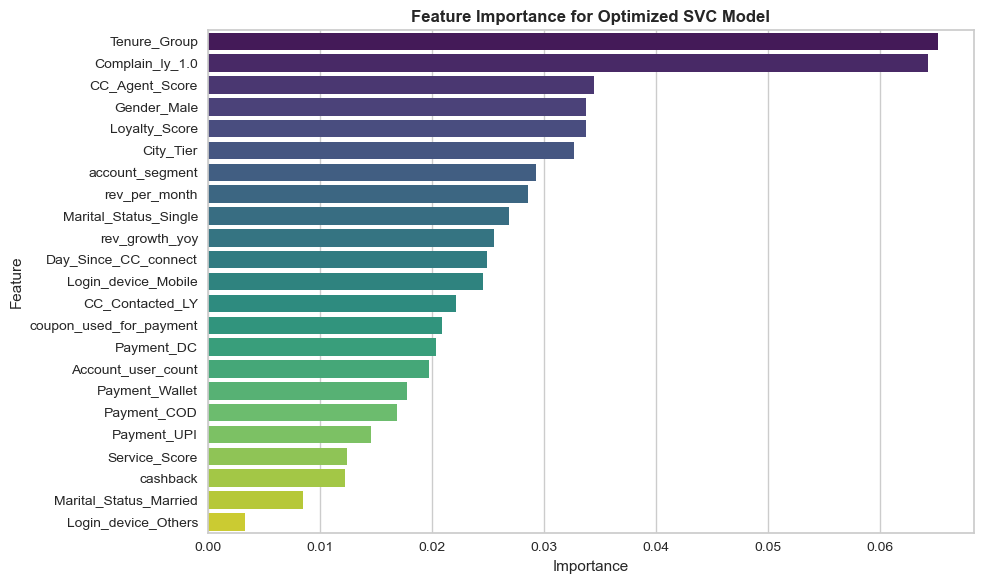

In [91]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette = 'viridis')
plt.title('Feature Importance for Optimized SVC Model',fontweight='bold')
plt.tight_layout()
plt.show()

**Observations**

**Top 3 Most Important Features:**
- **Tenure_Group**: Customer tenure is the most influential factor in predicting churn. This suggests that how long a customer has been associated with the company significantly impacts churn probability.
- **Complain_ly_1.0**: Customers who complained in the last year are highly likely to churn, indicating dissatisfaction.
- **CC_Agent_Score**: The quality of customer care interactions (e.g., service ratings) plays a critical role in retention.

**Demographics and Loyalty Factors:**
- **Gender_Male**: Male customers appear to have a higher correlation with churn compared to females.
- **Loyalty_Score**: Customer loyalty score significantly influences retention.
- **Marital_Status_Single**: Single customers may have a higher churn rate compared to married ones.

**Revenue and Payment Patterns:**
- **rev_per_month & rev_growth_yoy**: Monthly revenue and year-over-year revenue growth are key indicators of customer stability.
- **Payment_Wallet & Payment_UPI**: Certain payment methods are linked to churn behavior, possibly due to ease of transaction or subscription preferences.

**Customer Support & Engagement:**
- **CC_Contacted_LY**: Customers who interacted with customer support in the last year have a noticeable impact on churn, possibly reflecting past issues.
- **Day_Since_CC_Connect**: The number of days since the last contact with customer care also contributes to churn risk.

**Least Important Features:**
- **Marital_Status_Married & Login_device_Others** contribute minimally to churn prediction.
- **cashback**: Offering cashback might not be as influential in reducing churn as expected.

**Business Implications & Actions:**
- **Focus on customer tenure management**: Implement loyalty programs targeting long-term customers.
- **Enhance customer service**: Address complaints quickly to improve satisfaction.
- **Monitor revenue growth**: Identify declining revenue trends early.
- **Personalized engagement**: Use targeted offers based on customer demographics and past interactions.


#### **ROC-AUC Curve**

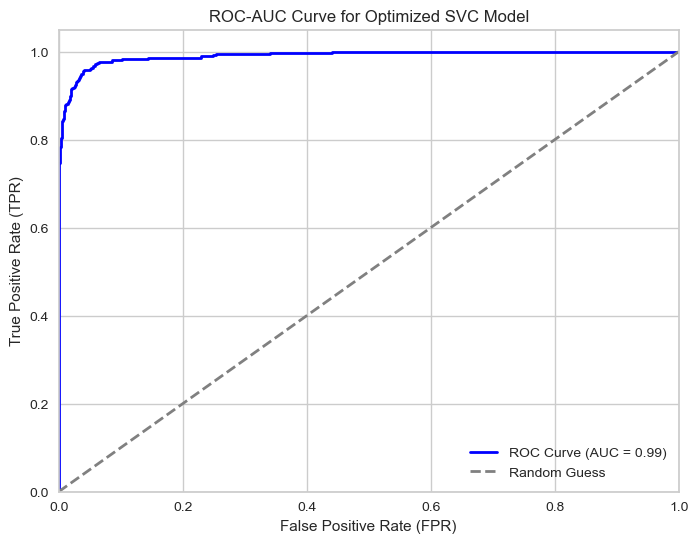

In [92]:
# Get predicted probabilities for the positive class (churn)
y_pred_proba = tuned_svm.predict_proba(X_test_cleaned)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-AUC Curve for Optimized SVC Model')
plt.legend(loc='lower right')
plt.show()

**Observations**
- **High AUC Score (0.99)**  
   - The model achieves an AUC of 0.99, indicating exceptional classification performance.  
   - This suggests that the model can effectively distinguish between positive and negative classes.  

- **Near-Perfect Performance**  
   - The ROC curve is close to the top-left corner, demonstrating high sensitivity (True Positive Rate) with very low False Positives.  
   - This means the model correctly identifies most positive cases while minimizing incorrect predictions.  

- **Minimal False Positives**  
   - The False Positive Rate (FPR) remains close to zero for most threshold values.  
   - This indicates that the model makes very few incorrect positive predictions.  

- **Strong Separation of Classes**  
   - The ROC curve (blue line) is significantly above the random classifier line (grey dashed line).  
   - This confirms that the model performs far better than random guessing.  

#### **Confusion Matrix**

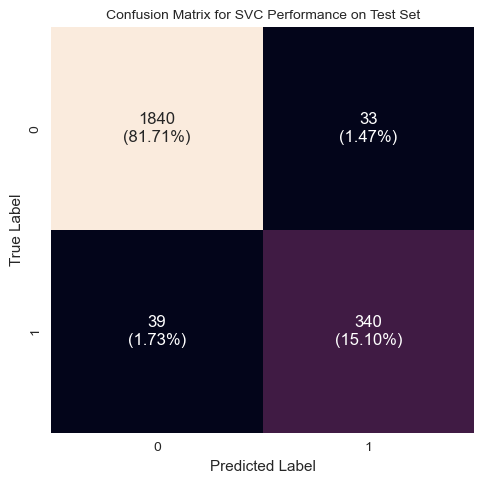

In [93]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(5,5))

# Call your function to plot the confusion matrix
confusion_matrix_sklearn(ax, tuned_svm, X_test_cleaned, y_test, title="Confusion Matrix for SVC Performance on Test Set")

plt.tight_layout()
plt.show()


**Observations**
- **High Recall (89.71%)**: The model successfully captures most churn cases, which is crucial for customer retention strategies.
- **Low False Negatives**: Only 39 actual churn cases were missed, meaning the model effectively identifies customers at risk of leaving.
- **Low False Positives**: With just 33 non-churn customers misclassified as churners, unnecessary interventions are minimal.


### **Key Insights and Business Recommendations**

#### **Model Implication on Business**

1. **High Recall (89.71%) Ensures Most Churners Are Identified**  
   - The model successfully flags customers likely to churn, enabling proactive retention strategies like personalized offers or engagement campaigns.


2. **False Negatives (39 Customers) Need Attention**  
   - These customers were actual churners but weren’t identified as such.  
   - Analyzing their profiles can help refine the model and improve targeting.


3. **False Positives (33 Customers Misclassified as Churners) Have a Minimal Business Impact**  
   - While some non-churners might receive unnecessary interventions, this is preferable to missing actual churners.  
   - The business can optimize retention strategies to ensure cost-effectiveness.


#### **Business Insights**

1. **Tenure Group & Complaints Are Key Indicators of Churn**  
   - Customers with shorter tenure are more likely to churn. Retention strategies should focus on new customers.
   - Complaints in the last year strongly influence churn. Improving customer service and addressing complaints proactively can reduce churn.

2. **Customer Service Score Matters**  
   - CC_Agent_Score and Loyalty_Score are among the top features. Customers who rate support poorly or have low loyalty scores are at high risk.  
   - Providing personalized offers and enhancing support quality can help retain customers.

3. **Revenue and Payment Methods Influence Churn**  
   - Higher revenue per month correlates with retention. Understanding spending patterns and incentivizing consistent spending can enhance retention.  
   - Payment methods like Wallet, UPI, and COD have lower importance but still contribute to churn. Offering more flexible and preferred payment options can improve customer experience.

4. **Demographics Play a Role**  
   - Gender (Male) and Marital Status (Single) appear as significant predictors. Tailored marketing campaigns targeting these demographics could improve engagement.  
   - City_Tier and Account Segment indicate that location and customer type influence churn behavior.



#### **Business Recommendations**

1. **Improve Customer Support & Issue Resolution**  
    Since complaints and CC_Agent_Score impact churn, a dedicated effort to resolve issues quickly will enhance customer satisfaction.

2. **Target At-Risk Segments with Personalized Offers**  
    Short-tenure, single, and male customers need engagement strategies such as loyalty rewards, discounts, and exclusive offers.

3. **Enhance Customer Onboarding & Early Retention**  
    Since tenure group is a key churn factor, improving onboarding, providing early engagement benefits, and implementing proactive check-ins can boost retention.

4. **Use Predictive Insights to Prioritize Interventions**  
    Focus retention efforts on customers with high churn probability based on key features like complaints, loyalty score, and revenue trends.

5. **Refine Marketing and Payment Strategies**  
    Offering preferred payment options and understanding revenue per month behavior can help reduce churn and increase customer lifetime value.

By acting on these insights, the business can significantly reduce churn, improve customer retention, and drive long-term profitability.